In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.set_style('whitegrid')
import h5py
from PIL import Image
import os
from tqdm.notebook import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/scratch/xc1490/projects/tmp/python_packages')
sys.path.append('/scratch/xc1490/projects/tmp/python_packages/') #pip install --target=/home/xc1490/home/projects/tmp/python_packages package_name

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('llm_compression.csv')

In [3]:
df

model  prune_ratio  quantized        c4   time1       ptb  \
0           Llama-13B         0.00          0      6.80  145.57     28.10   
1           sparsegpt         0.10          0      6.80  143.92     28.10   
2           sparsegpt         0.20          0      6.85  142.55     28.43   
3           sparsegpt         0.30          0      6.99  143.07     29.39   
4           sparsegpt         0.40          0      7.31  143.93     31.66   
5           sparsegpt         0.50          0      8.12  142.51     37.24   
6           sparsegpt         0.60          0     10.74  141.59     59.31   
7           sparsegpt         0.70          0     22.54  142.56    155.26   
8           sparsegpt         0.80          0     72.22  140.00    450.97   
9           sparsegpt         0.90          0    943.30  140.68   3264.86   
10           Llama-7B         0.00          0     10.25   98.25     31.76   
11    LLMpruner_block         0.25          0     22.83   75.19     72.61   
12    LLMpruner_block         0.40          0     35.93   61.58    118.33   
13    LLMpruner_block         0.50          0     72.13   50.55    211.76   
14    LLMpruner_block         0.60          0    180.21   41.34    347.78   
15  LLMpruner_channel         0.20          0    176.11   80.82    542.87   
16  LLMpruner_channel         0.30          0   3523.53   71.27   4653.21   
17  LLMpruner_channel         0.40          0   8038.63   59.99   9774.18   
18  LLMpruner_channel         0.50          0  11732.37   50.89  24381.08   
19          Llama-13B         0.00          1      7.15   26.86     31.26   
20           Llama-7B         0.00          1     12.84   18.36     33.48   
21          sparsegpt         0.10          1      9.52   29.22     38.98   
22          sparsegpt         0.20          1      9.58   28.94     39.43   
23          sparsegpt         0.30          1      9.78   29.04     40.76   
24          sparsegpt         0.40          1     10.23   29.22     43.91   
25          sparsegpt         0.50          1     11.36   28.93     51.65   
26          sparsegpt         0.60          1     15.02   28.74     82.27   
27          sparsegpt         0.70          1     31.53   28.94    215.34   
28          sparsegpt         0.80          1    101.04   28.42    625.50   
29          sparsegpt         0.90          1   1119.67   28.56   4228.36   
30    LLMpruner_block         0.25          1     32.78   17.37    108.05   
31    LLMpruner_block         0.40          1     51.60   14.22    176.07   
32    LLMpruner_block         0.50          1    103.58   11.68    315.10   
33    LLMpruner_block         0.60          1    258.78    9.55    517.49   
34  LLMpruner_channel         0.20          1    252.89   18.67    807.79   
35  LLMpruner_channel         0.30          1   5059.79   16.46   6923.98   
36  LLMpruner_channel         0.40          1  11543.47   13.86  14543.99   
37  LLMpruner_channel         0.50          1  16847.68   11.76  36279.04   

    time2  wikitext2   time3  Computational Complexity (GMac)  \
0   66.98       5.09  123.11                             0.00   
1   63.61       5.10  111.56                             0.00   
2   63.39       5.14  107.96                             0.00   
3   66.07       5.26  109.60                             0.00   
4   64.75       5.56  108.93                             0.00   
5   62.30       6.21  107.57                             0.00   
6   63.56       8.43  109.00                             0.00   
7   64.24      19.03  110.69                             0.00   
8   64.64      96.36  108.93                             0.00   
9   62.29    2400.34  106.60                             0.00   
10  43.26       5.97   82.35                           425.12   
11  34.85      19.24   63.34                           340.48   
12  27.48      31.23   52.40                           292.51   
13  23.75      65.10   43.86                           255.84   
14  19.14     166.87   34.50         

# structure vs unstructured vs vanilla

In [4]:
tmpdf = df[np.array(df['model'] == 'sparsegpt') & np.array(df['quantized'] == 0)]
tmpdf1 = df[np.array(['LLMpruner' in i for i in df['model']]) & np.array(df['quantized'] == 0)].iloc[:4].sort_values(by=['prune_ratio'])
tmpdf2 = df[np.array(['Llama' in i for i in df['model']]) & np.array(df['quantized'] == 0)].iloc[:4].sort_values(by=['prune_ratio'])
tmpdf2

model  prune_ratio  quantized     c4   time1    ptb  time2  wikitext2  \
0   Llama-13B          0.0          0   6.80  145.57  28.10  66.98       5.09   
10   Llama-7B          0.0          0  10.25   98.25  31.76  43.26       5.97   

     time3  Computational Complexity (GMac)  Number of Parameters (M)  \
0   123.11                             0.00                      0.00   
10   82.35                           425.12                   6738.42   

    GPU Memory Requirements (MiB)  
0                            0.00  
10                       12924.65

In [5]:
np.where((df['model'] == 'sparsegpt') & (df['quantized'] == 0))

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),)

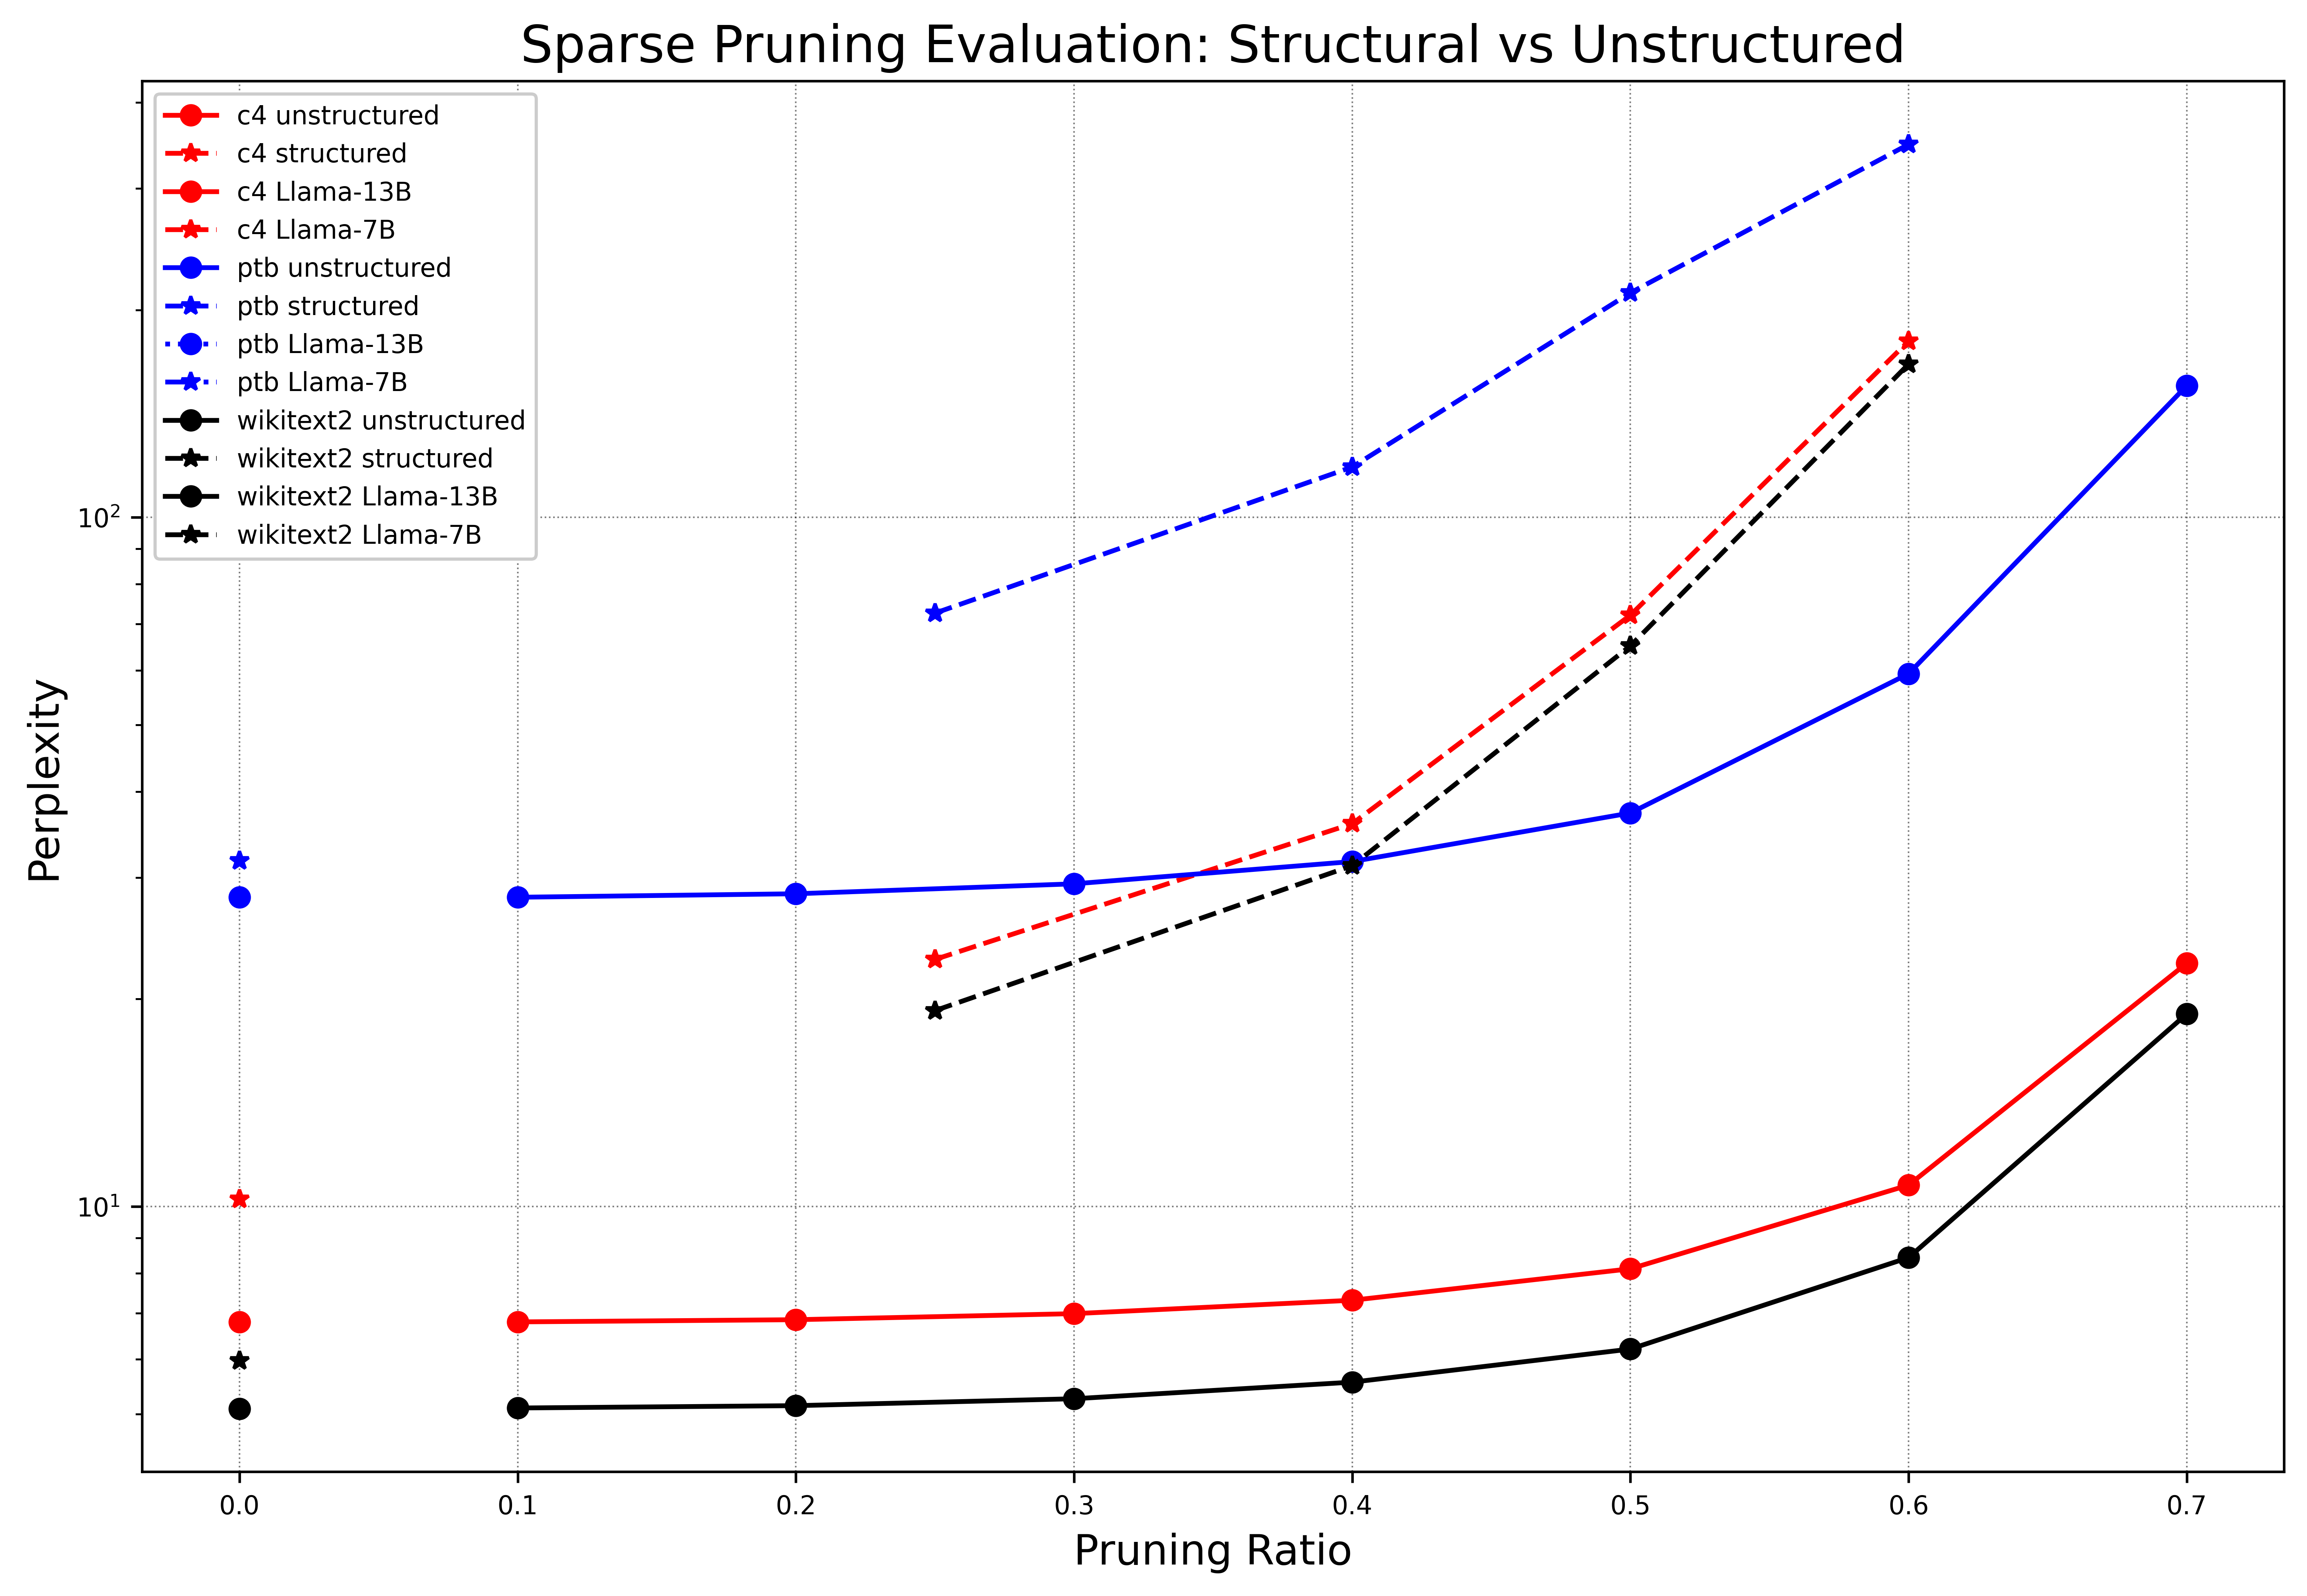

In [6]:
with plt.style.context(['ieee', 'grid', 'no-latex']):
    prune_ratio = 0.7
    fig,ax = plt.subplots(figsize=(12, 8))
    # Plot for each dataset
    colors = ['red','blue','black']
    for count, column in enumerate(['c4','ptb','wikitext2']):
        ax.plot(tmpdf[tmpdf['prune_ratio'] <=prune_ratio]['prune_ratio'], tmpdf[tmpdf['prune_ratio']\
                                <=prune_ratio][column], marker='o',linestyle='-',color = colors[count], label=column + ' unstructured')
        ax.plot(tmpdf1[tmpdf1['prune_ratio'] <=prune_ratio]['prune_ratio'],  tmpdf1[tmpdf1['prune_ratio']\
                                <=prune_ratio][column], marker='*',linestyle='--', color = colors[count],label=column + ' structured')
        for count1, model_name in enumerate(['Llama-13B','Llama-7B']):
            tmpdf3 = tmpdf2[tmpdf2['model'] == model_name]
            ax.plot(tmpdf3[tmpdf3['prune_ratio'] <=prune_ratio]['prune_ratio'],  tmpdf3[tmpdf3['prune_ratio']\
                                <=prune_ratio][column], marker=['o','*'][count1],  color = colors[count],label=column + ' '+model_name)

    ax.set_title('Sparse Pruning Evaluation: Structural vs Unstructured',fontsize=16)
    ax.set_xlabel('Pruning Ratio',fontsize=13)
    ax.set_ylabel('Perplexity',fontsize=13)
    ax.legend()
    ax.grid(True)
    plt.yscale('log')
    plt.show()
    fig.savefig('figs/structure_vs_unstructure.png'.format(prune_ratio))

# quantized vs pruned vs vanilla

In [39]:
tmpdf = df[np.array(df['model'] == 'sparsegpt') & np.array(df['quantized'] == 1)]
tmpdf1 = df[np.array(['LLMpruner' in i for i in df['model']]) & np.array(df['quantized'] == 1)].iloc[:4].sort_values(by=['prune_ratio'])
tmpdf2 = df[np.array(['Llama' in i for i in df['model']]) & np.array(df['quantized'] == 1)].iloc[:4].sort_values(by=['prune_ratio'])
tmpdf2

model  prune_ratio  quantized     c4  time1    ptb  time2  wikitext2  \
19  Llama-13B          0.0          1   7.15  26.86  31.26  13.12       5.32   
20   Llama-7B          0.0          1  12.84  18.36  33.48   8.09       7.08   

    time3  Computational Complexity (GMac)  Number of Parameters (M)  \
19  25.97                              0.0                       0.0   
20  15.39                              0.0                       0.0   

    GPU Memory Requirements (MiB)  
19                            0.0  
20                            0.0

In [40]:
tmpdf_ = df[np.array(df['model'] == 'sparsegpt') & np.array(df['quantized'] == 0)]
tmpdf1_ = df[np.array(['LLMpruner' in i for i in df['model']]) & np.array(df['quantized'] == 0)].iloc[:4].sort_values(by=['prune_ratio'])
tmpdf2_ = df[np.array(['Llama' in i for i in df['model']]) & np.array(df['quantized'] == 0)].iloc[:4].sort_values(by=['prune_ratio'])
tmpdf2

model  prune_ratio  quantized     c4  time1    ptb  time2  wikitext2  \
19  Llama-13B          0.0          1   7.15  26.86  31.26  13.12       5.32   
20   Llama-7B          0.0          1  12.84  18.36  33.48   8.09       7.08   

    time3  Computational Complexity (GMac)  Number of Parameters (M)  \
19  25.97                              0.0                       0.0   
20  15.39                              0.0                       0.0   

    GPU Memory Requirements (MiB)  
19                            0.0  
20                            0.0

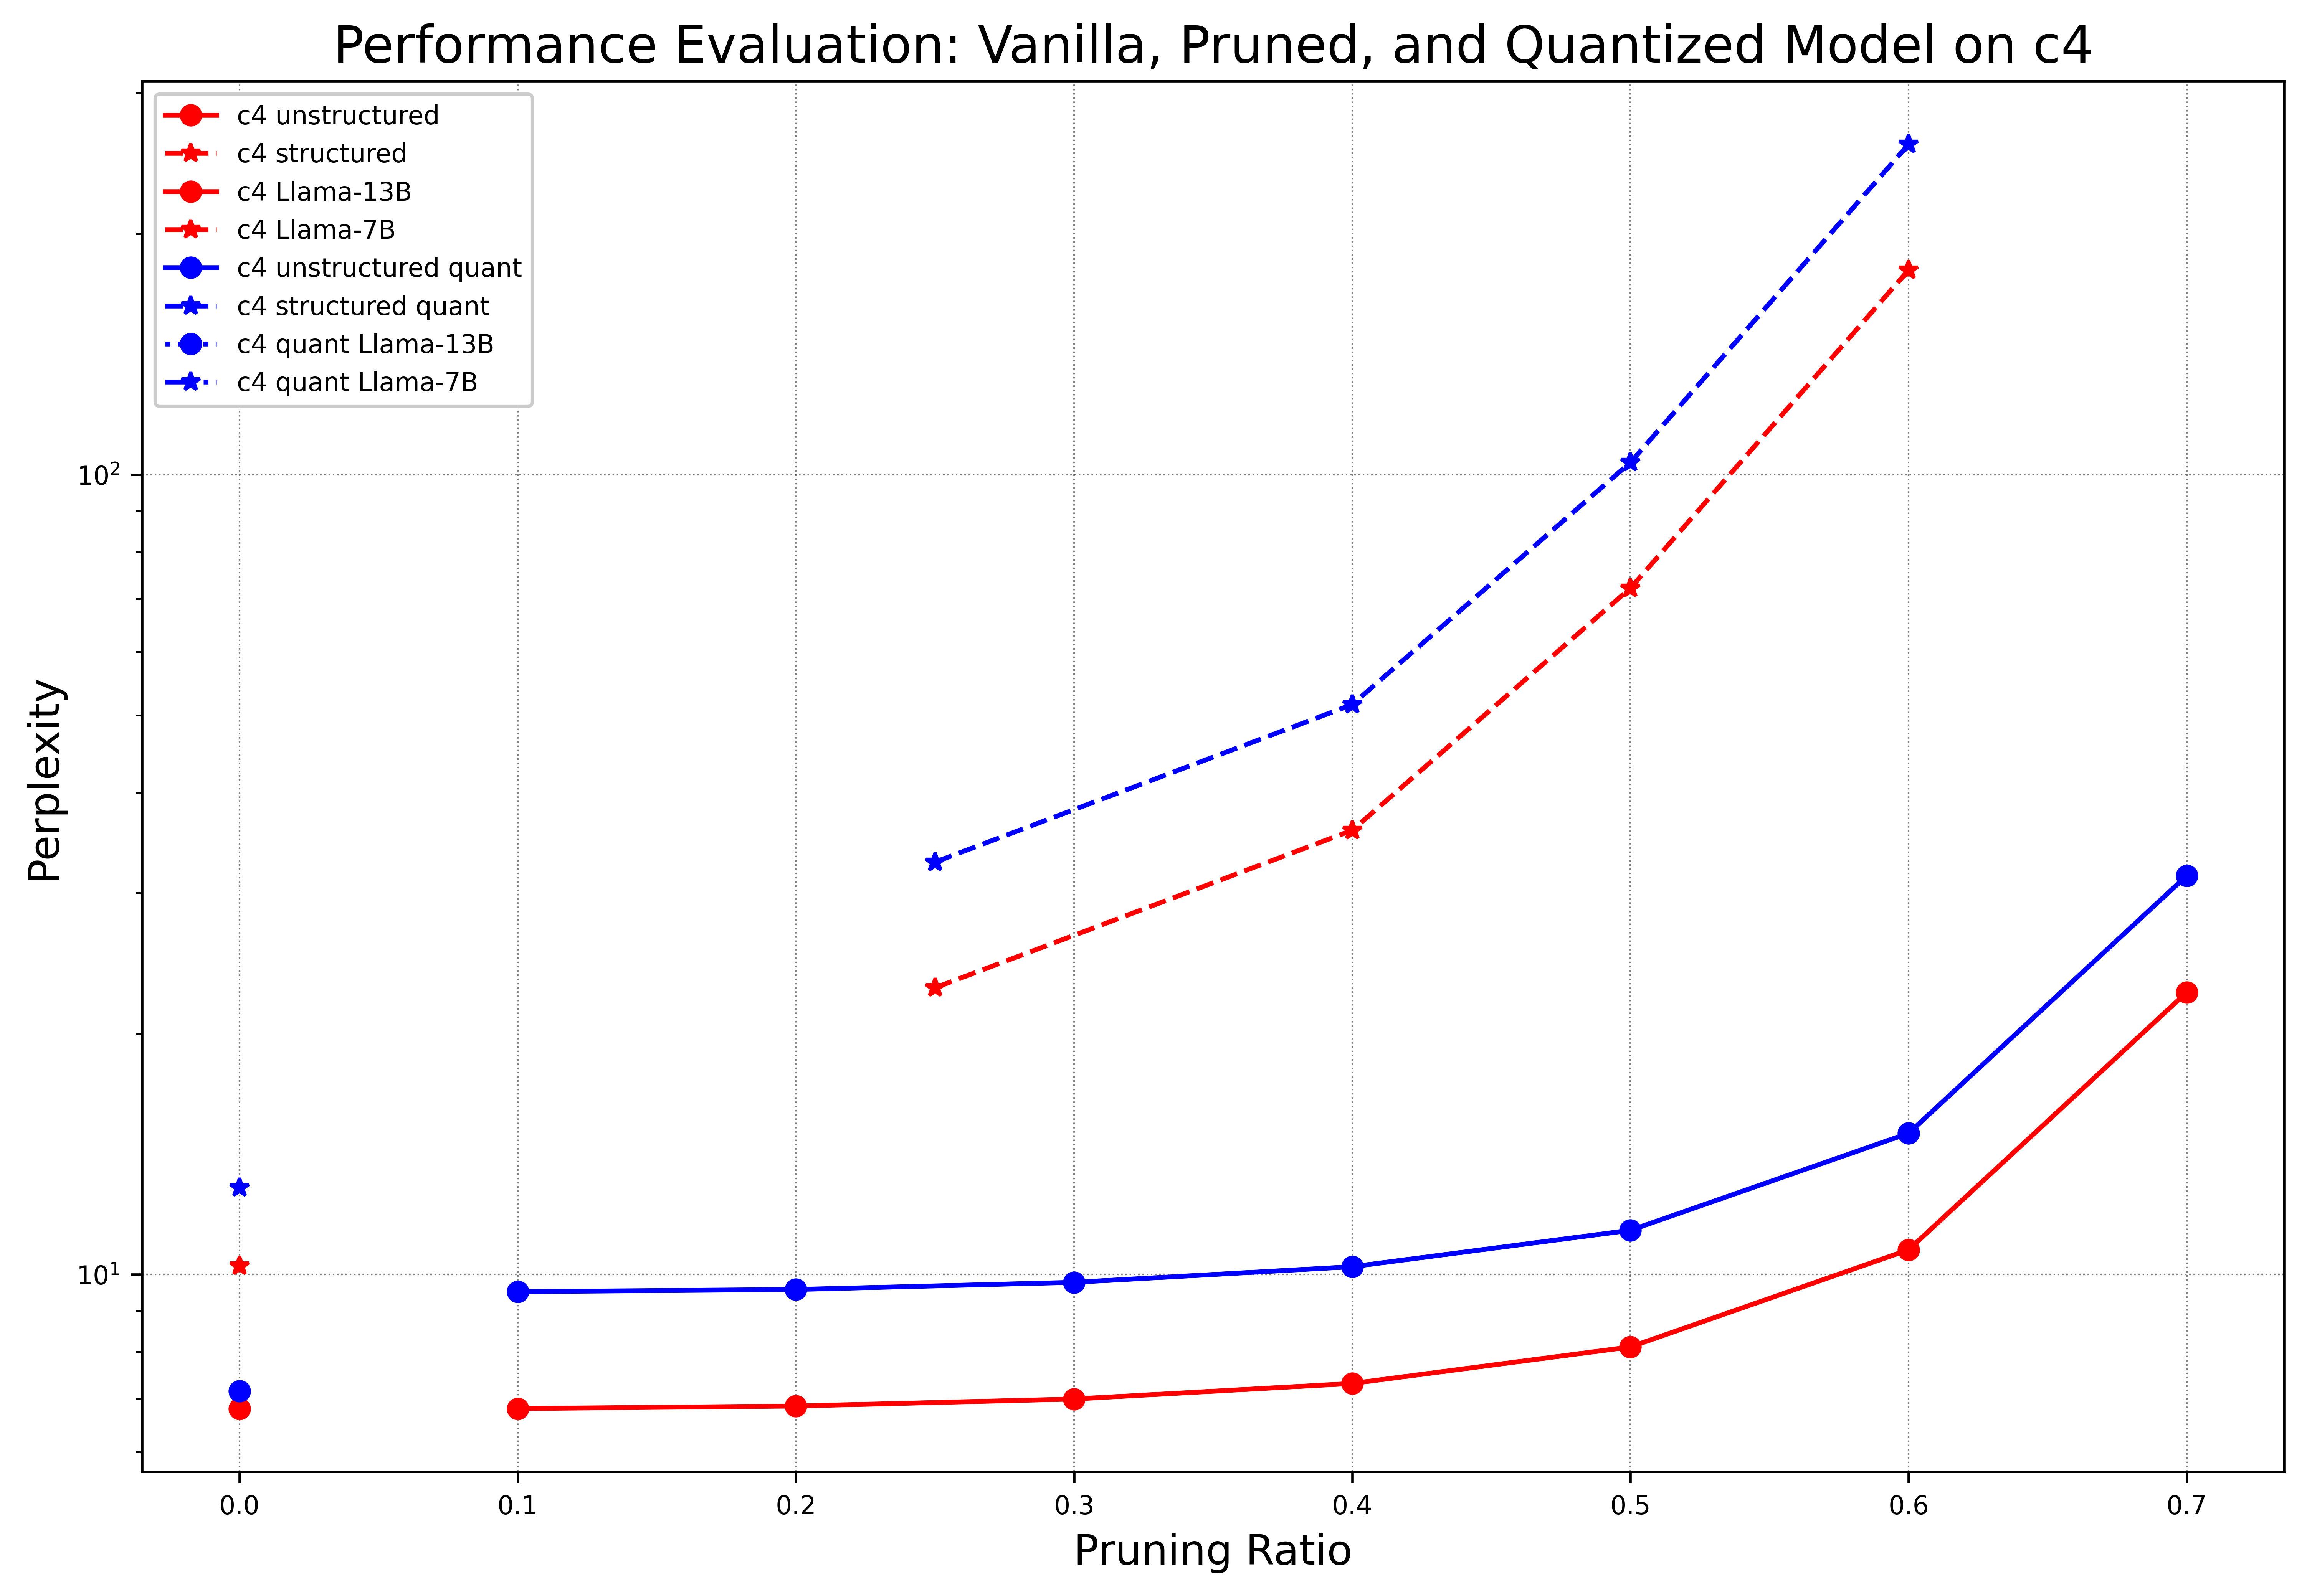

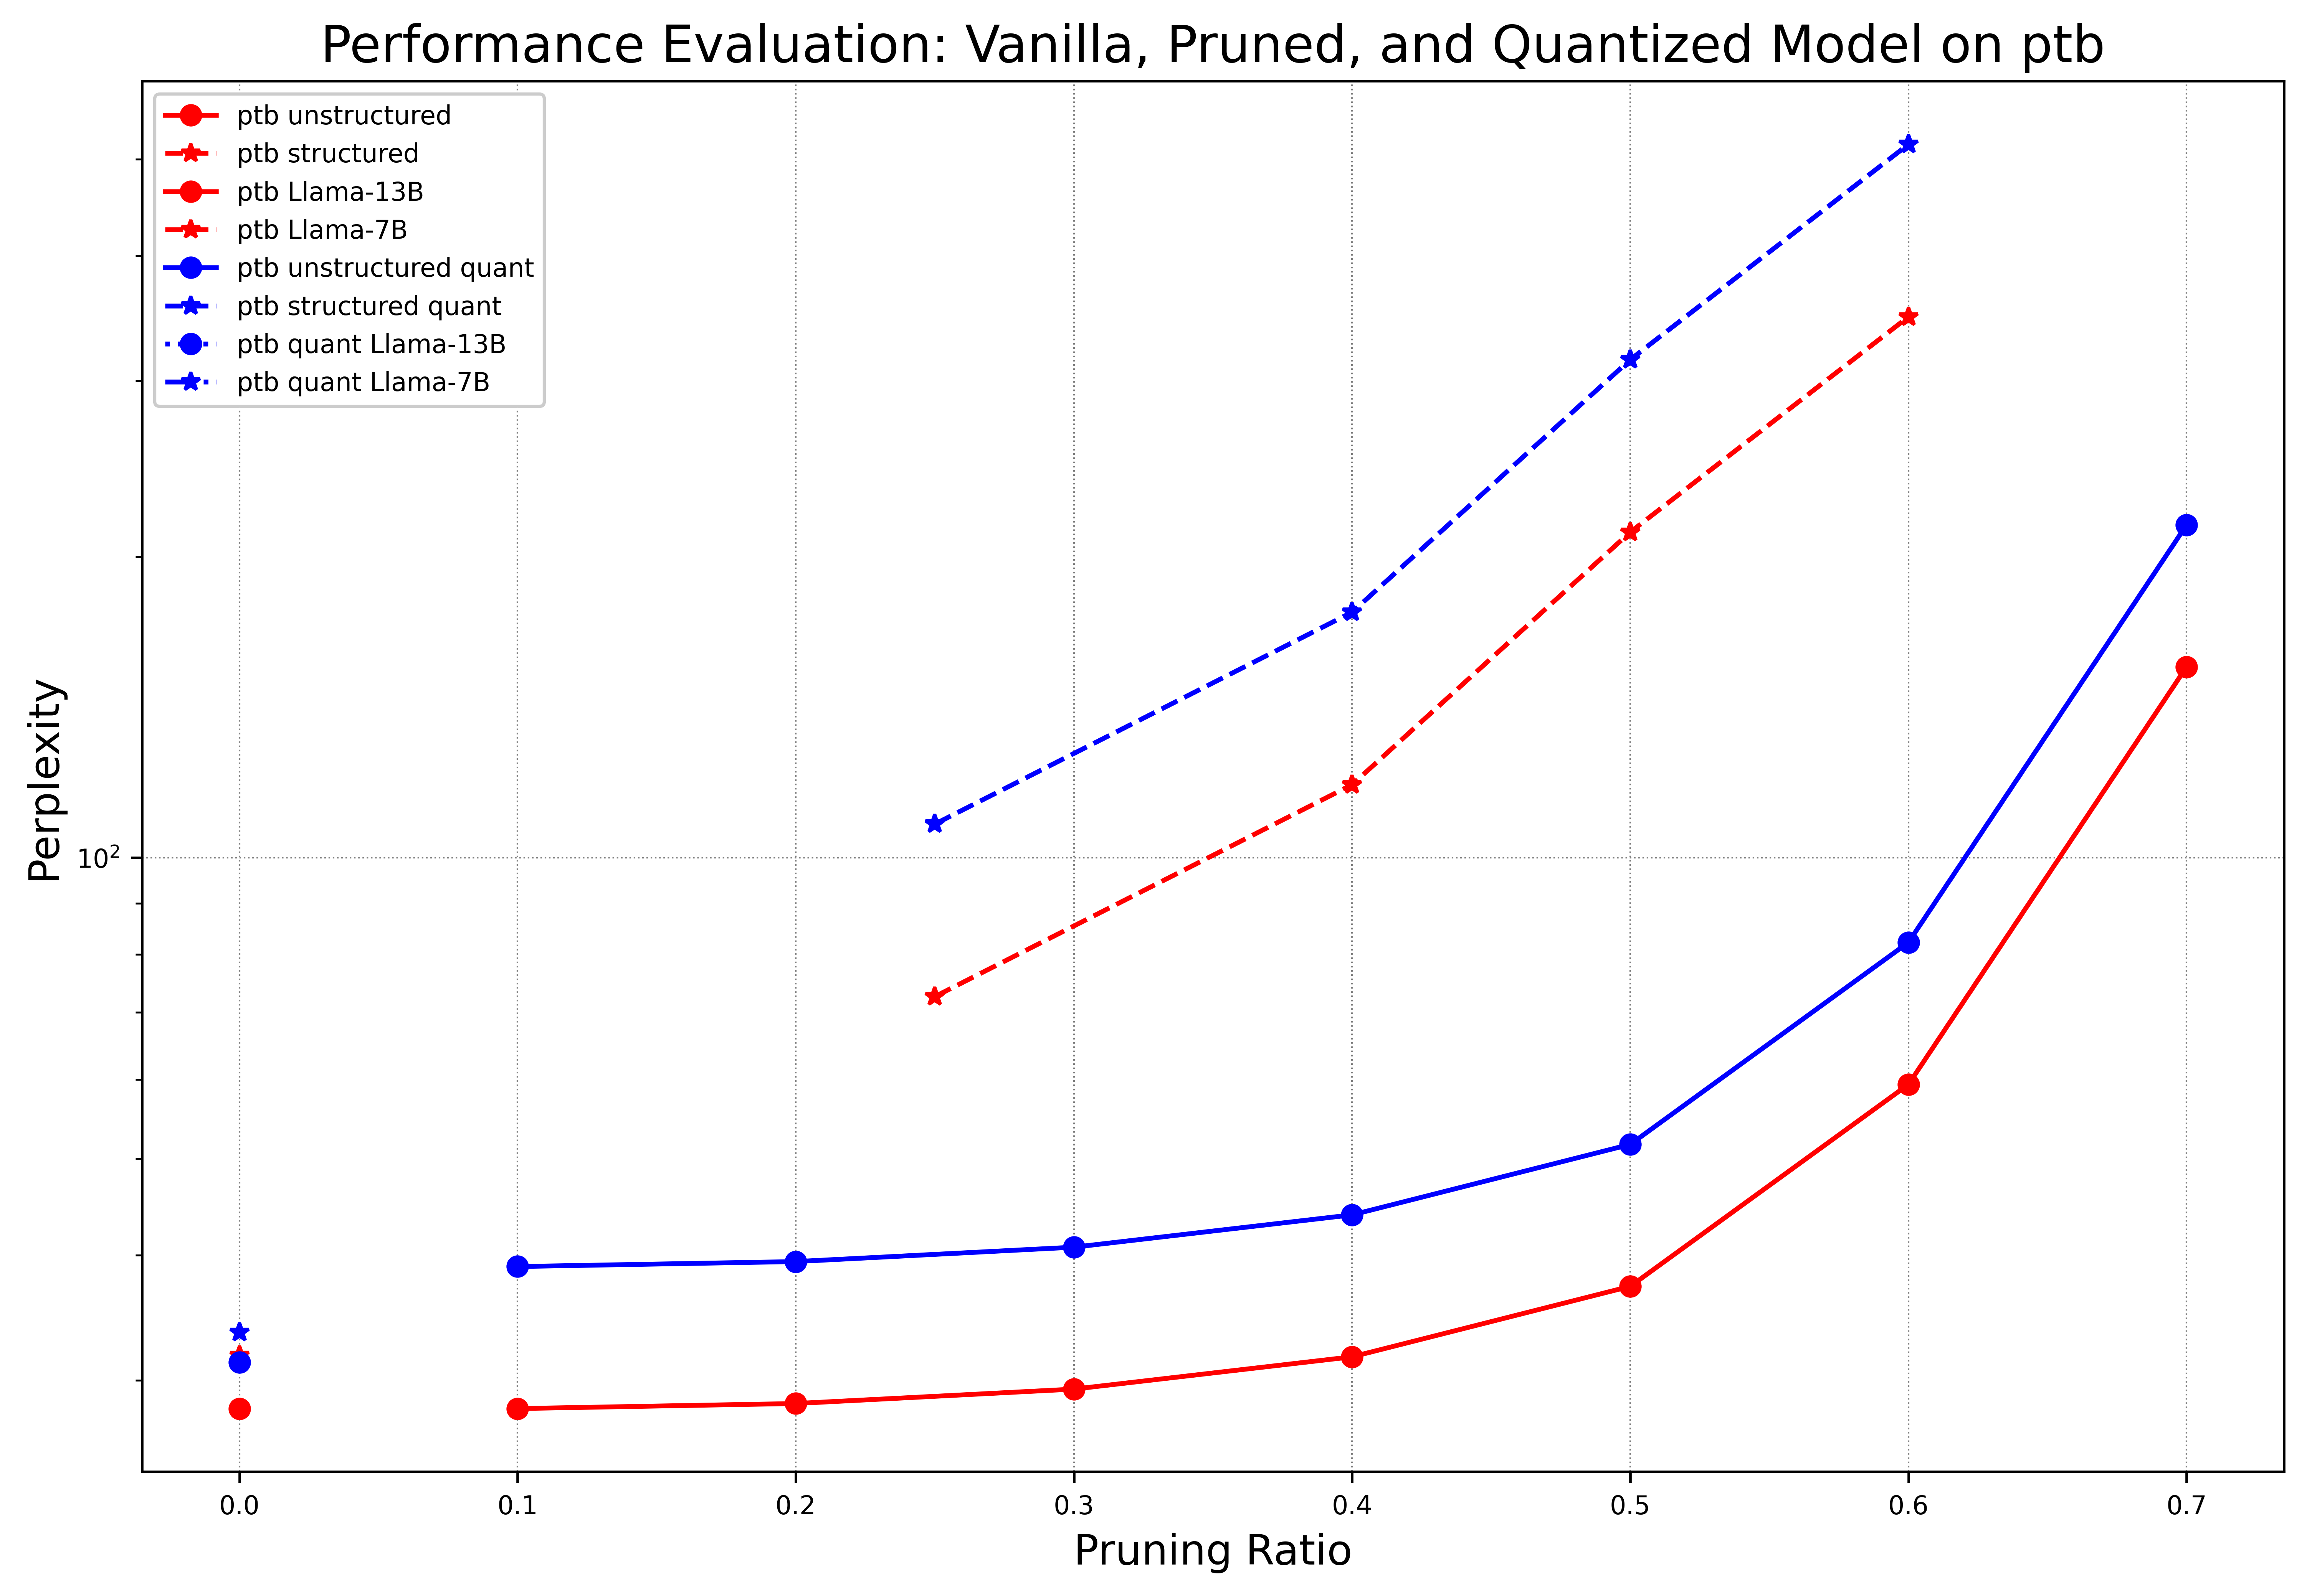

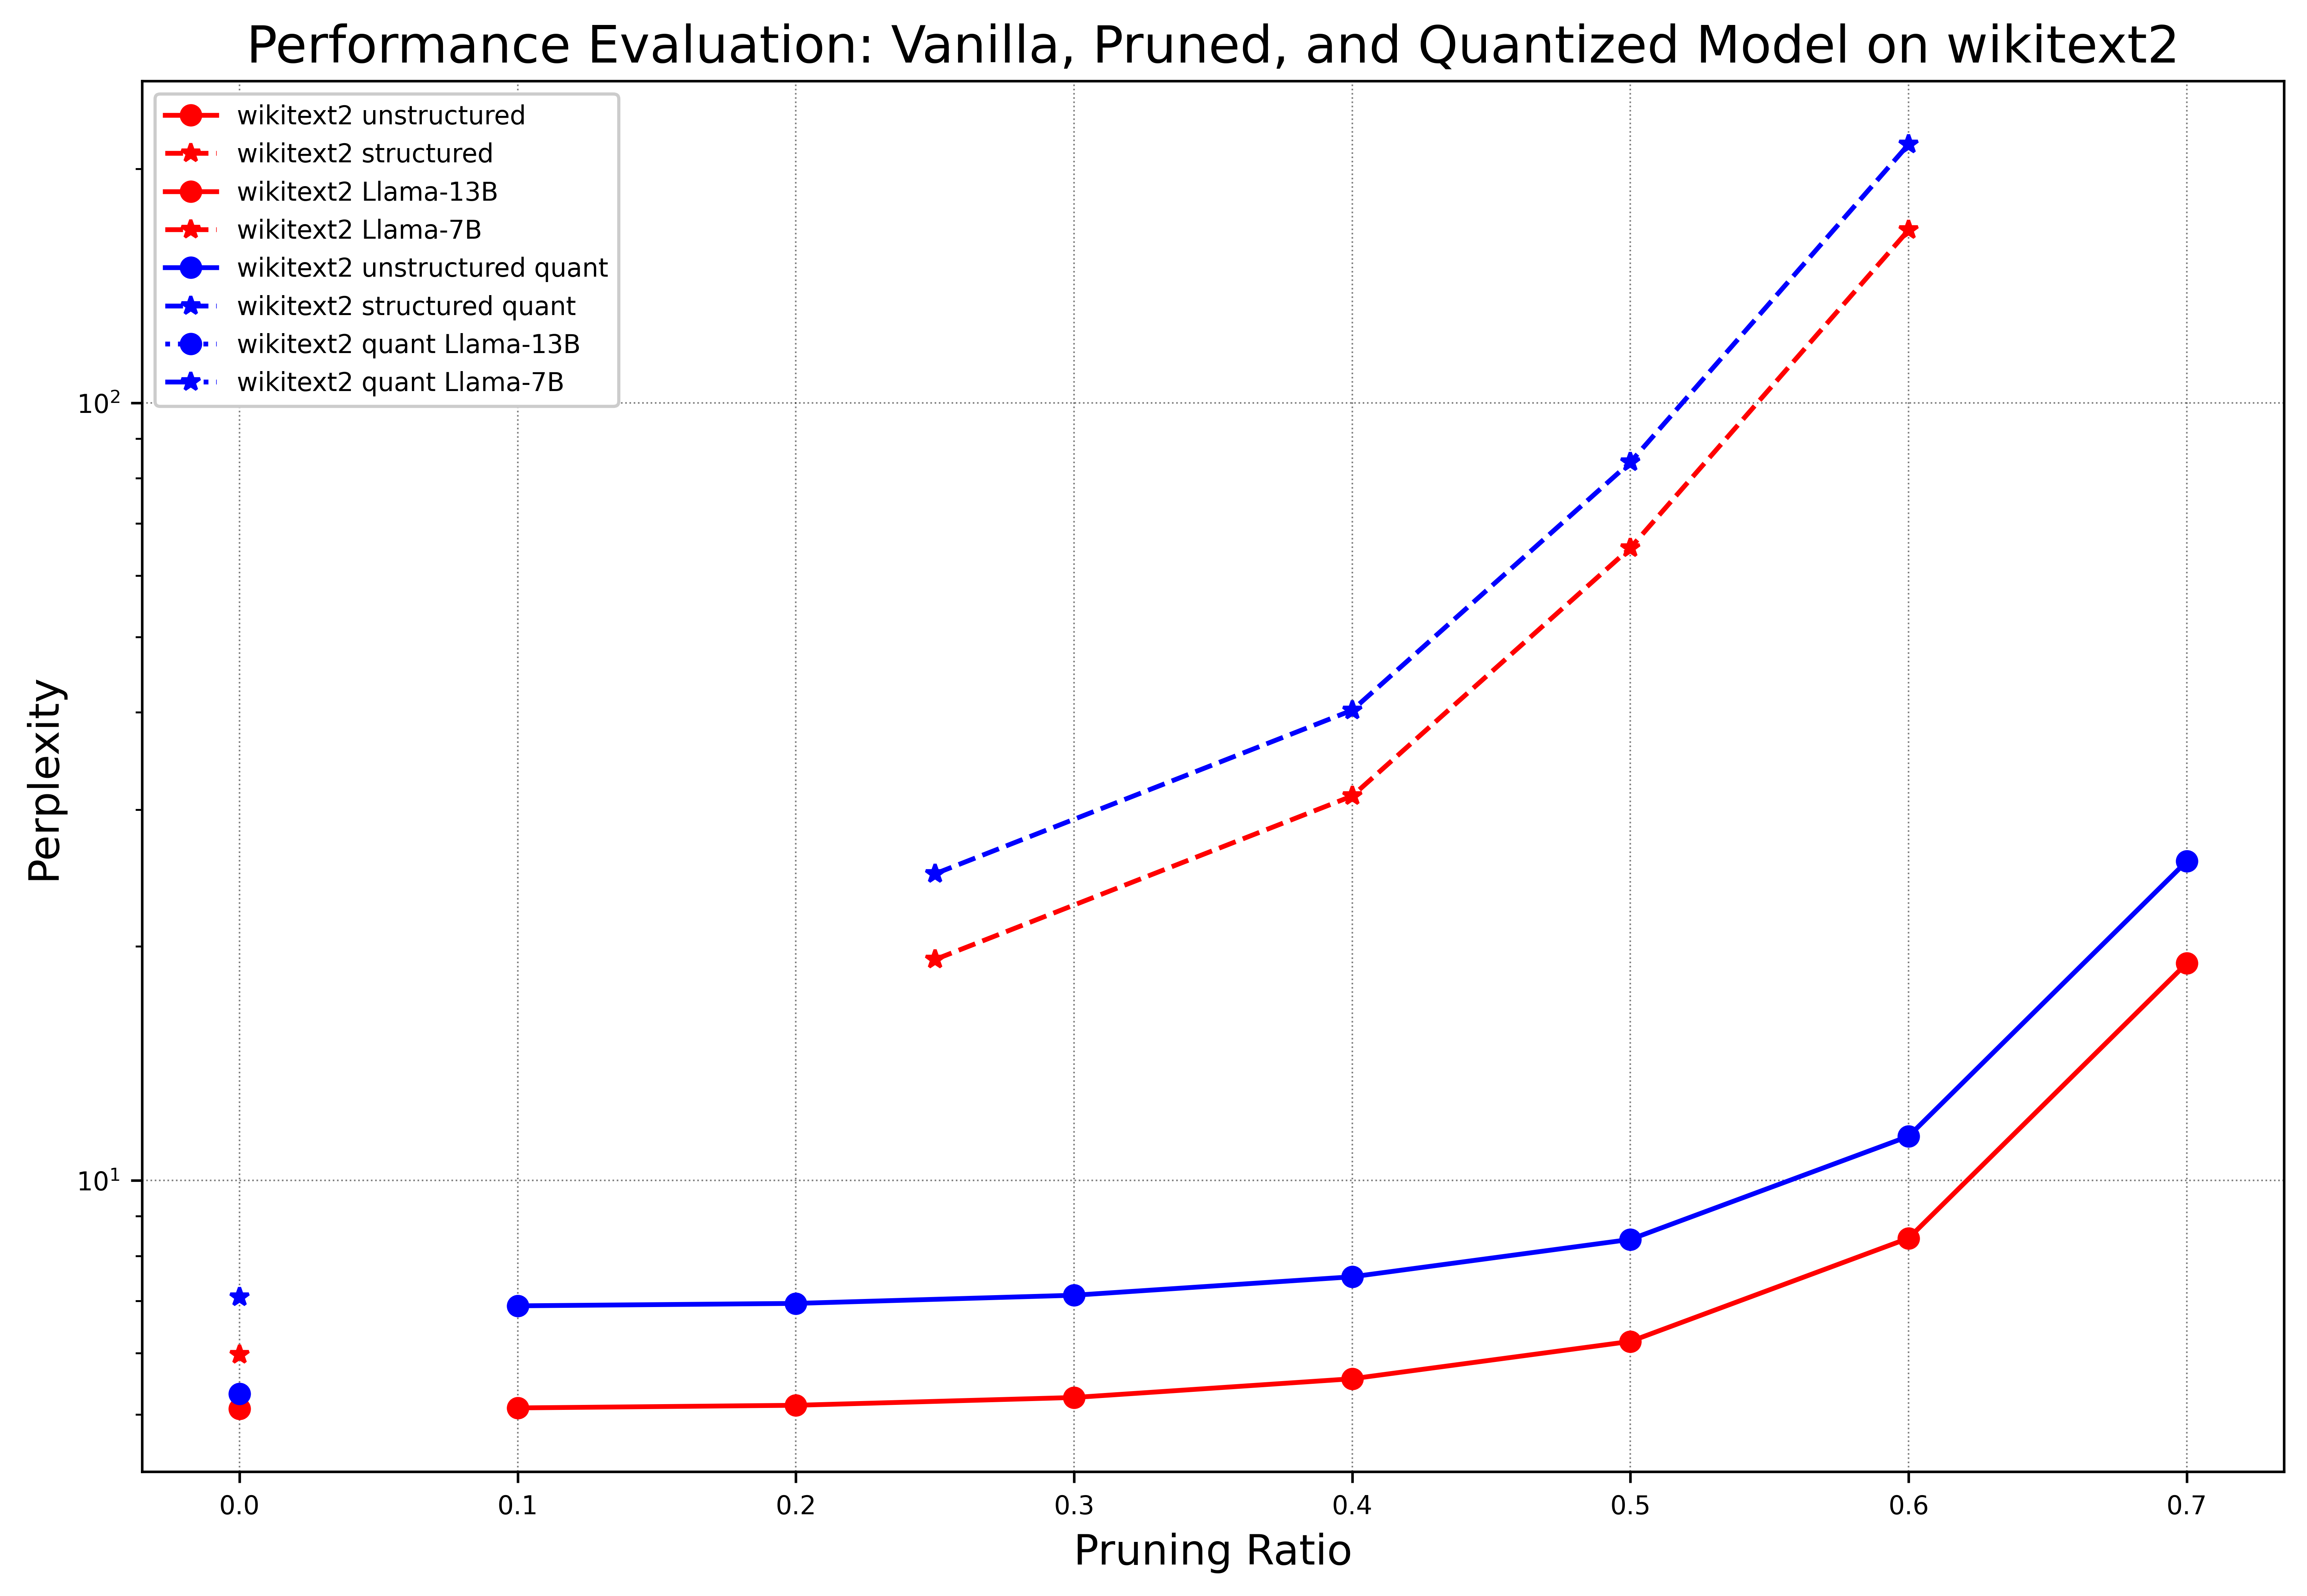

In [41]:
with plt.style.context(['ieee', 'grid', 'no-latex']):
    prune_ratio = 0.7

    # Plot for each dataset
    colors = ['red','blue','black']
    for dataset in ['c4','ptb','wikitext2']:
        fig,ax = plt.subplots(figsize=(12, 8))
        for count, column in enumerate([dataset]):
            ax.plot(tmpdf_[tmpdf_['prune_ratio'] <=prune_ratio]['prune_ratio'], tmpdf_[tmpdf_['prune_ratio']\
                                    <=prune_ratio][column], marker='o',linestyle='-',color = colors[0], label=column + ' unstructured')
            ax.plot(tmpdf1_[tmpdf1_['prune_ratio'] <=prune_ratio]['prune_ratio'],  tmpdf1_[tmpdf1_['prune_ratio']\
                                    <=prune_ratio][column], marker='*',linestyle='--', color = colors[0],label=column + ' structured')
            for count1, model_name in enumerate(['Llama-13B','Llama-7B']):
                tmpdf3_ = tmpdf2_[tmpdf2_['model'] == model_name]
                ax.plot(tmpdf3_[tmpdf3_['prune_ratio'] <=prune_ratio]['prune_ratio'],  tmpdf3_[tmpdf3_['prune_ratio']\
                                    <=prune_ratio][column], marker=['o','*'][count1],  color = colors[0],label=column + ' '+model_name)

        for count, column in enumerate([dataset]):
            ax.plot(tmpdf[tmpdf['prune_ratio'] <=prune_ratio]['prune_ratio'], tmpdf[tmpdf['prune_ratio']\
                                    <=prune_ratio][column], marker='o',linestyle='-',color = colors[1], label=column + ' unstructured quant')
            ax.plot(tmpdf1[tmpdf1['prune_ratio'] <=prune_ratio]['prune_ratio'],  tmpdf1[tmpdf1['prune_ratio']\
                                    <=prune_ratio][column], marker='*',linestyle='--', color = colors[1],label=column + ' structured quant')
            for count1, model_name in enumerate(['Llama-13B','Llama-7B']):
                tmpdf3 = tmpdf2[tmpdf2['model'] == model_name]
                ax.plot(tmpdf3[tmpdf3['prune_ratio'] <=prune_ratio]['prune_ratio'],  tmpdf3[tmpdf3['prune_ratio']\
                                    <=prune_ratio][column], marker=['o','*'][count1],  color = colors[1],label=column + ' quant '+model_name)


        ax.set_title('Performance Evaluation: Vanilla, Pruned, and Quantized Model on {}'.format(dataset),fontsize=16)
        ax.set_xlabel('Pruning Ratio',fontsize=13)
        ax.set_ylabel('Perplexity',fontsize=13)
        ax.legend()
        ax.grid(True)
        plt.yscale('log')
        plt.show()
        fig.savefig('figs/quantized_model_performance_{}.png'.format(dataset))

# performance vs time

In [10]:
df

model  prune_ratio  quantized        c4   time1       ptb  \
0           Llama-13B         0.00          0      6.80  145.57     28.10   
1           sparsegpt         0.10          0      6.80  143.92     28.10   
2           sparsegpt         0.20          0      6.85  142.55     28.43   
3           sparsegpt         0.30          0      6.99  143.07     29.39   
4           sparsegpt         0.40          0      7.31  143.93     31.66   
5           sparsegpt         0.50          0      8.12  142.51     37.24   
6           sparsegpt         0.60          0     10.74  141.59     59.31   
7           sparsegpt         0.70          0     22.54  142.56    155.26   
8           sparsegpt         0.80          0     72.22  140.00    450.97   
9           sparsegpt         0.90          0    943.30  140.68   3264.86   
10           Llama-7B         0.00          0     10.25   98.25     31.76   
11    LLMpruner_block         0.25          0     22.83   75.19     72.61   
12    LLMpruner_block         0.40          0     35.93   61.58    118.33   
13    LLMpruner_block         0.50          0     72.13   50.55    211.76   
14    LLMpruner_block         0.60          0    180.21   41.34    347.78   
15  LLMpruner_channel         0.20          0    176.11   80.82    542.87   
16  LLMpruner_channel         0.30          0   3523.53   71.27   4653.21   
17  LLMpruner_channel         0.40          0   8038.63   59.99   9774.18   
18  LLMpruner_channel         0.50          0  11732.37   50.89  24381.08   
19          Llama-13B         0.00          1      7.15   26.86     31.26   
20           Llama-7B         0.00          1     12.84   18.36     33.48   
21          sparsegpt         0.10          1      9.52   29.22     38.98   
22          sparsegpt         0.20          1      9.58   28.94     39.43   
23          sparsegpt         0.30          1      9.78   29.04     40.76   
24          sparsegpt         0.40          1     10.23   29.22     43.91   
25          sparsegpt         0.50          1     11.36   28.93     51.65   
26          sparsegpt         0.60          1     15.02   28.74     82.27   
27          sparsegpt         0.70          1     31.53   28.94    215.34   
28          sparsegpt         0.80          1    101.04   28.42    625.50   
29          sparsegpt         0.90          1   1119.67   28.56   4228.36   
30    LLMpruner_block         0.25          1     32.78   17.37    108.05   
31    LLMpruner_block         0.40          1     51.60   14.22    176.07   
32    LLMpruner_block         0.50          1    103.58   11.68    315.10   
33    LLMpruner_block         0.60          1    258.78    9.55    517.49   
34  LLMpruner_channel         0.20          1    252.89   18.67    807.79   
35  LLMpruner_channel         0.30          1   5059.79   16.46   6923.98   
36  LLMpruner_channel         0.40          1  11543.47   13.86  14543.99   
37  LLMpruner_channel         0.50          1  16847.68   11.76  36279.04   

    time2  wikitext2   time3  Computational Complexity (GMac)  \
0   66.98       5.09  123.11                             0.00   
1   63.61       5.10  111.56                             0.00   
2   63.39       5.14  107.96                             0.00   
3   66.07       5.26  109.60                             0.00   
4   64.75       5.56  108.93                             0.00   
5   62.30       6.21  107.57                             0.00   
6   63.56       8.43  109.00                             0.00   
7   64.24      19.03  110.69                             0.00   
8   64.64      96.36  108.93                             0.00   
9   62.29    2400.34  106.60                             0.00   
10  43.26       5.97   82.35                           425.12   
11  34.85      19.24   63.34                           340.48   
12  27.48      31.23   52.40                           292.51   
13  23.75      65.10   43.86                           255.84   
14  19.14     166.87   34.50         

In [42]:
tmpdf = df[np.array(['LLMpruner_channel' not in i for i in df['model']]) & np.array(df['prune_ratio'] <=0.6)]
tmpdf['model'] = [i + ['',' '][np.array(tmpdf['quantized'])[count]] for count, i in enumerate(np.array(tmpdf['model']))]
tmpdf = tmpdf.iloc[np.array([0,12,7,13,1,2,3,4,5,6,14,15,16,17,18,19,8,9,10,11,20,21,22,23]),:]
#tmpdf['model'] = np.concatenate((np.repeat(np.array(['Llama-13B']),2),np.repeat(np.array(['Llama-7B']),2),np.repeat(np.array(['Unstructured']),12),\
#np.repeat(np.array(['Structured']),8)))

In [43]:
tmpdf

model  prune_ratio  quantized      c4   time1     ptb  time2  \
0          Llama-13B         0.00          0    6.80  145.57   28.10  66.98   
19        Llama-13B          0.00          1    7.15   26.86   31.26  13.12   
10          Llama-7B         0.00          0   10.25   98.25   31.76  43.26   
20         Llama-7B          0.00          1   12.84   18.36   33.48   8.09   
1          sparsegpt         0.10          0    6.80  143.92   28.10  63.61   
2          sparsegpt         0.20          0    6.85  142.55   28.43  63.39   
3          sparsegpt         0.30          0    6.99  143.07   29.39  66.07   
4          sparsegpt         0.40          0    7.31  143.93   31.66  64.75   
5          sparsegpt         0.50          0    8.12  142.51   37.24  62.30   
6          sparsegpt         0.60          0   10.74  141.59   59.31  63.56   
21        sparsegpt          0.10          1    9.52   29.22   38.98  12.28   
22        sparsegpt          0.20          1    9.58   28.94   39.43  12.23   
23        sparsegpt          0.30          1    9.78   29.04   40.76  12.75   
24        sparsegpt          0.40          1   10.23   29.22   43.91  12.50   
25        sparsegpt          0.50          1   11.36   28.93   51.65  12.02   
26        sparsegpt          0.60          1   15.02   28.74   82.27  12.27   
11   LLMpruner_block         0.25          0   22.83   75.19   72.61  34.85   
12   LLMpruner_block         0.40          0   35.93   61.58  118.33  27.48   
13   LLMpruner_block         0.50          0   72.13   50.55  211.76  23.75   
14   LLMpruner_block         0.60          0  180.21   41.34  347.78  19.14   
30  LLMpruner_block          0.25          1   32.78   17.37  108.05   7.88   
31  LLMpruner_block          0.40          1   51.60   14.22  176.07   6.21   
32  LLMpruner_block          0.50          1  103.58   11.68  315.10   5.37   
33  LLMpruner_block          0.60          1  258.78    9.55  517.49   4.32   

    wikitext2   time3  Computational Complexity (GMac)  \
0        5.09  123.11                             0.00   
19       5.32   25.97                             0.00   
10       5.97   82.35                           425.12   
20       7.08   15.39                             0.00   
1        5.10  111.56                             0.00   
2        5.14  107.96                             0.00   
3        5.26  109.60                             0.00   
4        5.56  108.93                             0.00   
5        6.21  107.57                             0.00   
6        8.43  109.00                             0.00   
21       6.90   24.43                             0.00   
22       6.95   23.64                             0.00   
23       7.12   24.00                             0.00   
24       7.52   23.86                             0.00   
25       8.40   23.56                             0.00   
26      11.40   23.87                             0.00   
11      19.24   63.34                           340.48   
12      31.23   52.40                           292.51   
13      65.10   43.86                           255.84   
14     166.87   34.50                           222.69   
30      24.80   11.40                             0.00   
31      40.26    9.43                             0.00   
32      83.91    7.89                             0.00   
33     215.09    6.21                             0.00   

    Number of Parameters (M)  GPU Memory Requirements (MiB)  
0                       0.00                           0.00  
19                      0.00                           0.00  
10                   6738.42                       12924.65  
20                      0.00                           0.00  
1                       0.00                           0.00  
2                       0.00                           0.00  
3                       0.00                           0.00  
4                       0.00                           0.00  
5                       0.00  

In [44]:
np.unique(tmpdf['model'])

array(['LLMpruner_block', 'LLMpruner_block ', 'Llama-13B', 'Llama-13B ',
       'Llama-7B', 'Llama-7B ', 'sparsegpt', 'sparsegpt '], dtype=object)

In [50]:
import plotly
import plotly.express as px
key_xs = ['time1','time2','time3']
#with open(save_path+'all_{}_bubble.html'.format(key_x), 'a') as f:
for count, key_y in enumerate(['c4','ptb','wikitext2']):
    fig = px.scatter(tmpdf,   x='model', y=key_y,
            size=key_xs[count], color='model',
                     hover_name="prune_ratio", log_x=False, size_max=60)
    fig.update_layout(title="Llama Model Performance and Inference time {}".format(key_y),
                      title_x=0.5,
                      yaxis=dict(title='Perplexity',type='log' ),
                      xaxis=dict(title='Model',
                      #gridcolor='gray',
                      #tickmode= 'array',
                      #tickmode= 'linear',
                      #tick0= 2050,
                      #dtick=2,
                      tickvals= np.arange(0,8),
                      ticktext = np.array(['Llama-13B','Llama-13B','Llama-7B','Llama-7B','Unstructured','Unstructured','Structured','Structured'])),
                      font_family="Courier New",
                        font_color="black", title_font_family="Times New Roman",
                        title_font_color="black", legend_title_font_color="green",
                      font=dict( family="Times New Roman", size=15,color='#000000'),
                      width=900,height=450 
                     )
    legend_names = {'LLMpruner_block': 'Structured', 'LLMpruner_block ': 'Structured Quant',\
                   'sparsegpt': 'Unstructured', 'sparsegpt ': 'Unstructured Quant',\
                   'Llama-7B': 'Llama-7B', 'Llama-7B ': 'Llama-7B Quant',\
                   'Llama-13B': 'Llama-13B', 'Llama-13B ': 'Llama-13B Quant'}
    fig.for_each_trace(lambda t: t.update(name = legend_names[t.name]))
#     legend_names = {'LLMpruner_block, 0': 'Structured, 0', 'LLMpruner_block , 1': 'Structured, 1',\
#                    'sparsegpt, 0': 'Unstructured, 0', 'sparsegpt , 1': 'Unstructured, 1',\
#                    'Llama-7B, 0': 'Llama-7B, 0', 'Llama-7B , 1': 'Llama-7B, 1',\
#                    'Llama-13B, 0': 'Llama-13B, 0', 'Llama-13B , 1': 'Llama-13B, 1'}
#     fig.for_each_trace(lambda t: t.update(name = legend_names[t.name]))
    fig.show()
#     f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
    fig.write_image('figs/bubble_{}.png'.format(key_y),scale=1 ) 
    fig.write_image('figs/bubble_{}.pdf'.format(key_y) ) 
#     fig.write_image(save_path+'bubble/'+'{}_{}_bubble.png'.format(key_x,key_y)) 
#     plotly.offline.plot(fig, filename=save_path+'bubble/'+'{}_{}_bubble'.format(key_x,key_y), auto_open=False);

In [57]:
tmpdf = df[np.array(['LLMpruner_channel' not in i for i in df['model']]) & np.array(df['prune_ratio'] <=0.6)]
tmpdf['model'] = [i + ['',' quant'][np.array(tmpdf['quantized'])[count]] for count, i in enumerate(np.array(tmpdf['model']))]
tmpdf = tmpdf.iloc[np.array([0,12,7,13,1,2,3,4,5,6,14,15,16,17,18,19,8,9,10,11,20,21,22,23]),:]
tmpdf['model'] = np.concatenate((np.repeat(np.array(['Llama-13B', 'Llama-13B quant']),1),\
                                 np.repeat(np.array(['Llama-7B', 'Llama-7B quant']),1),\
                                 np.repeat(np.array(['Unstructured', 'Unstructured quant']),6),\
np.repeat(np.array(['Structured','Structured quant']),4)))

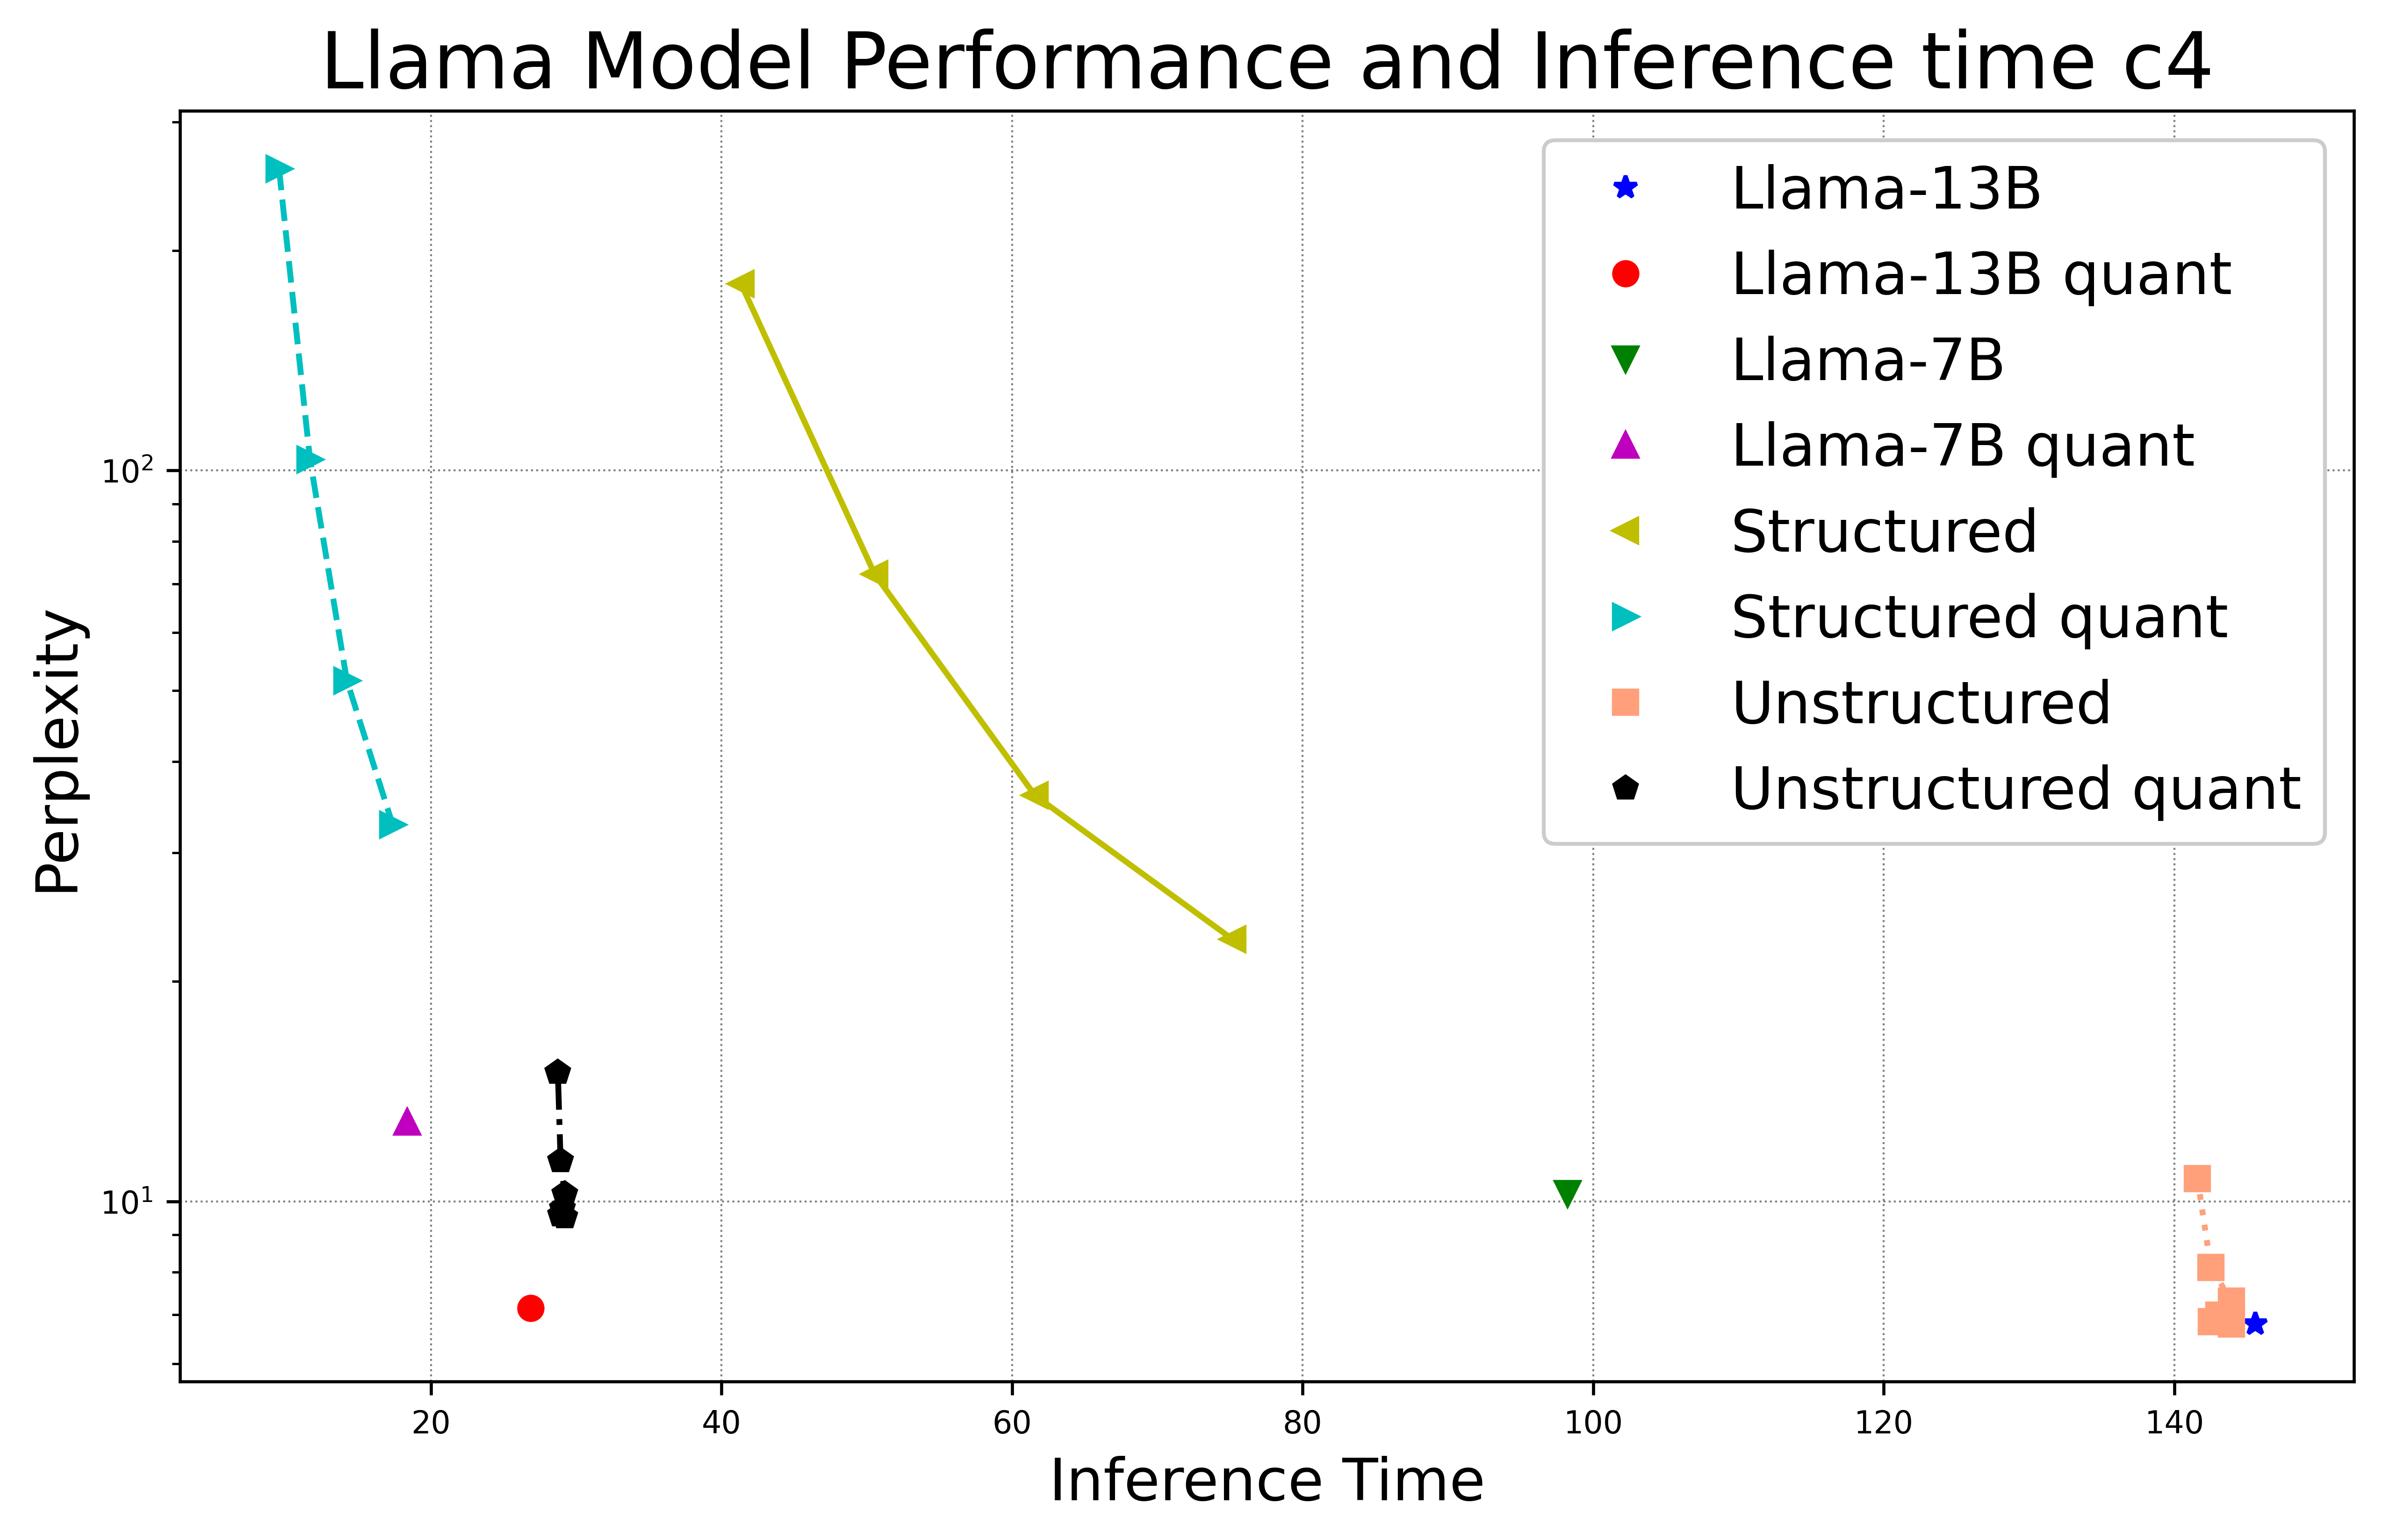

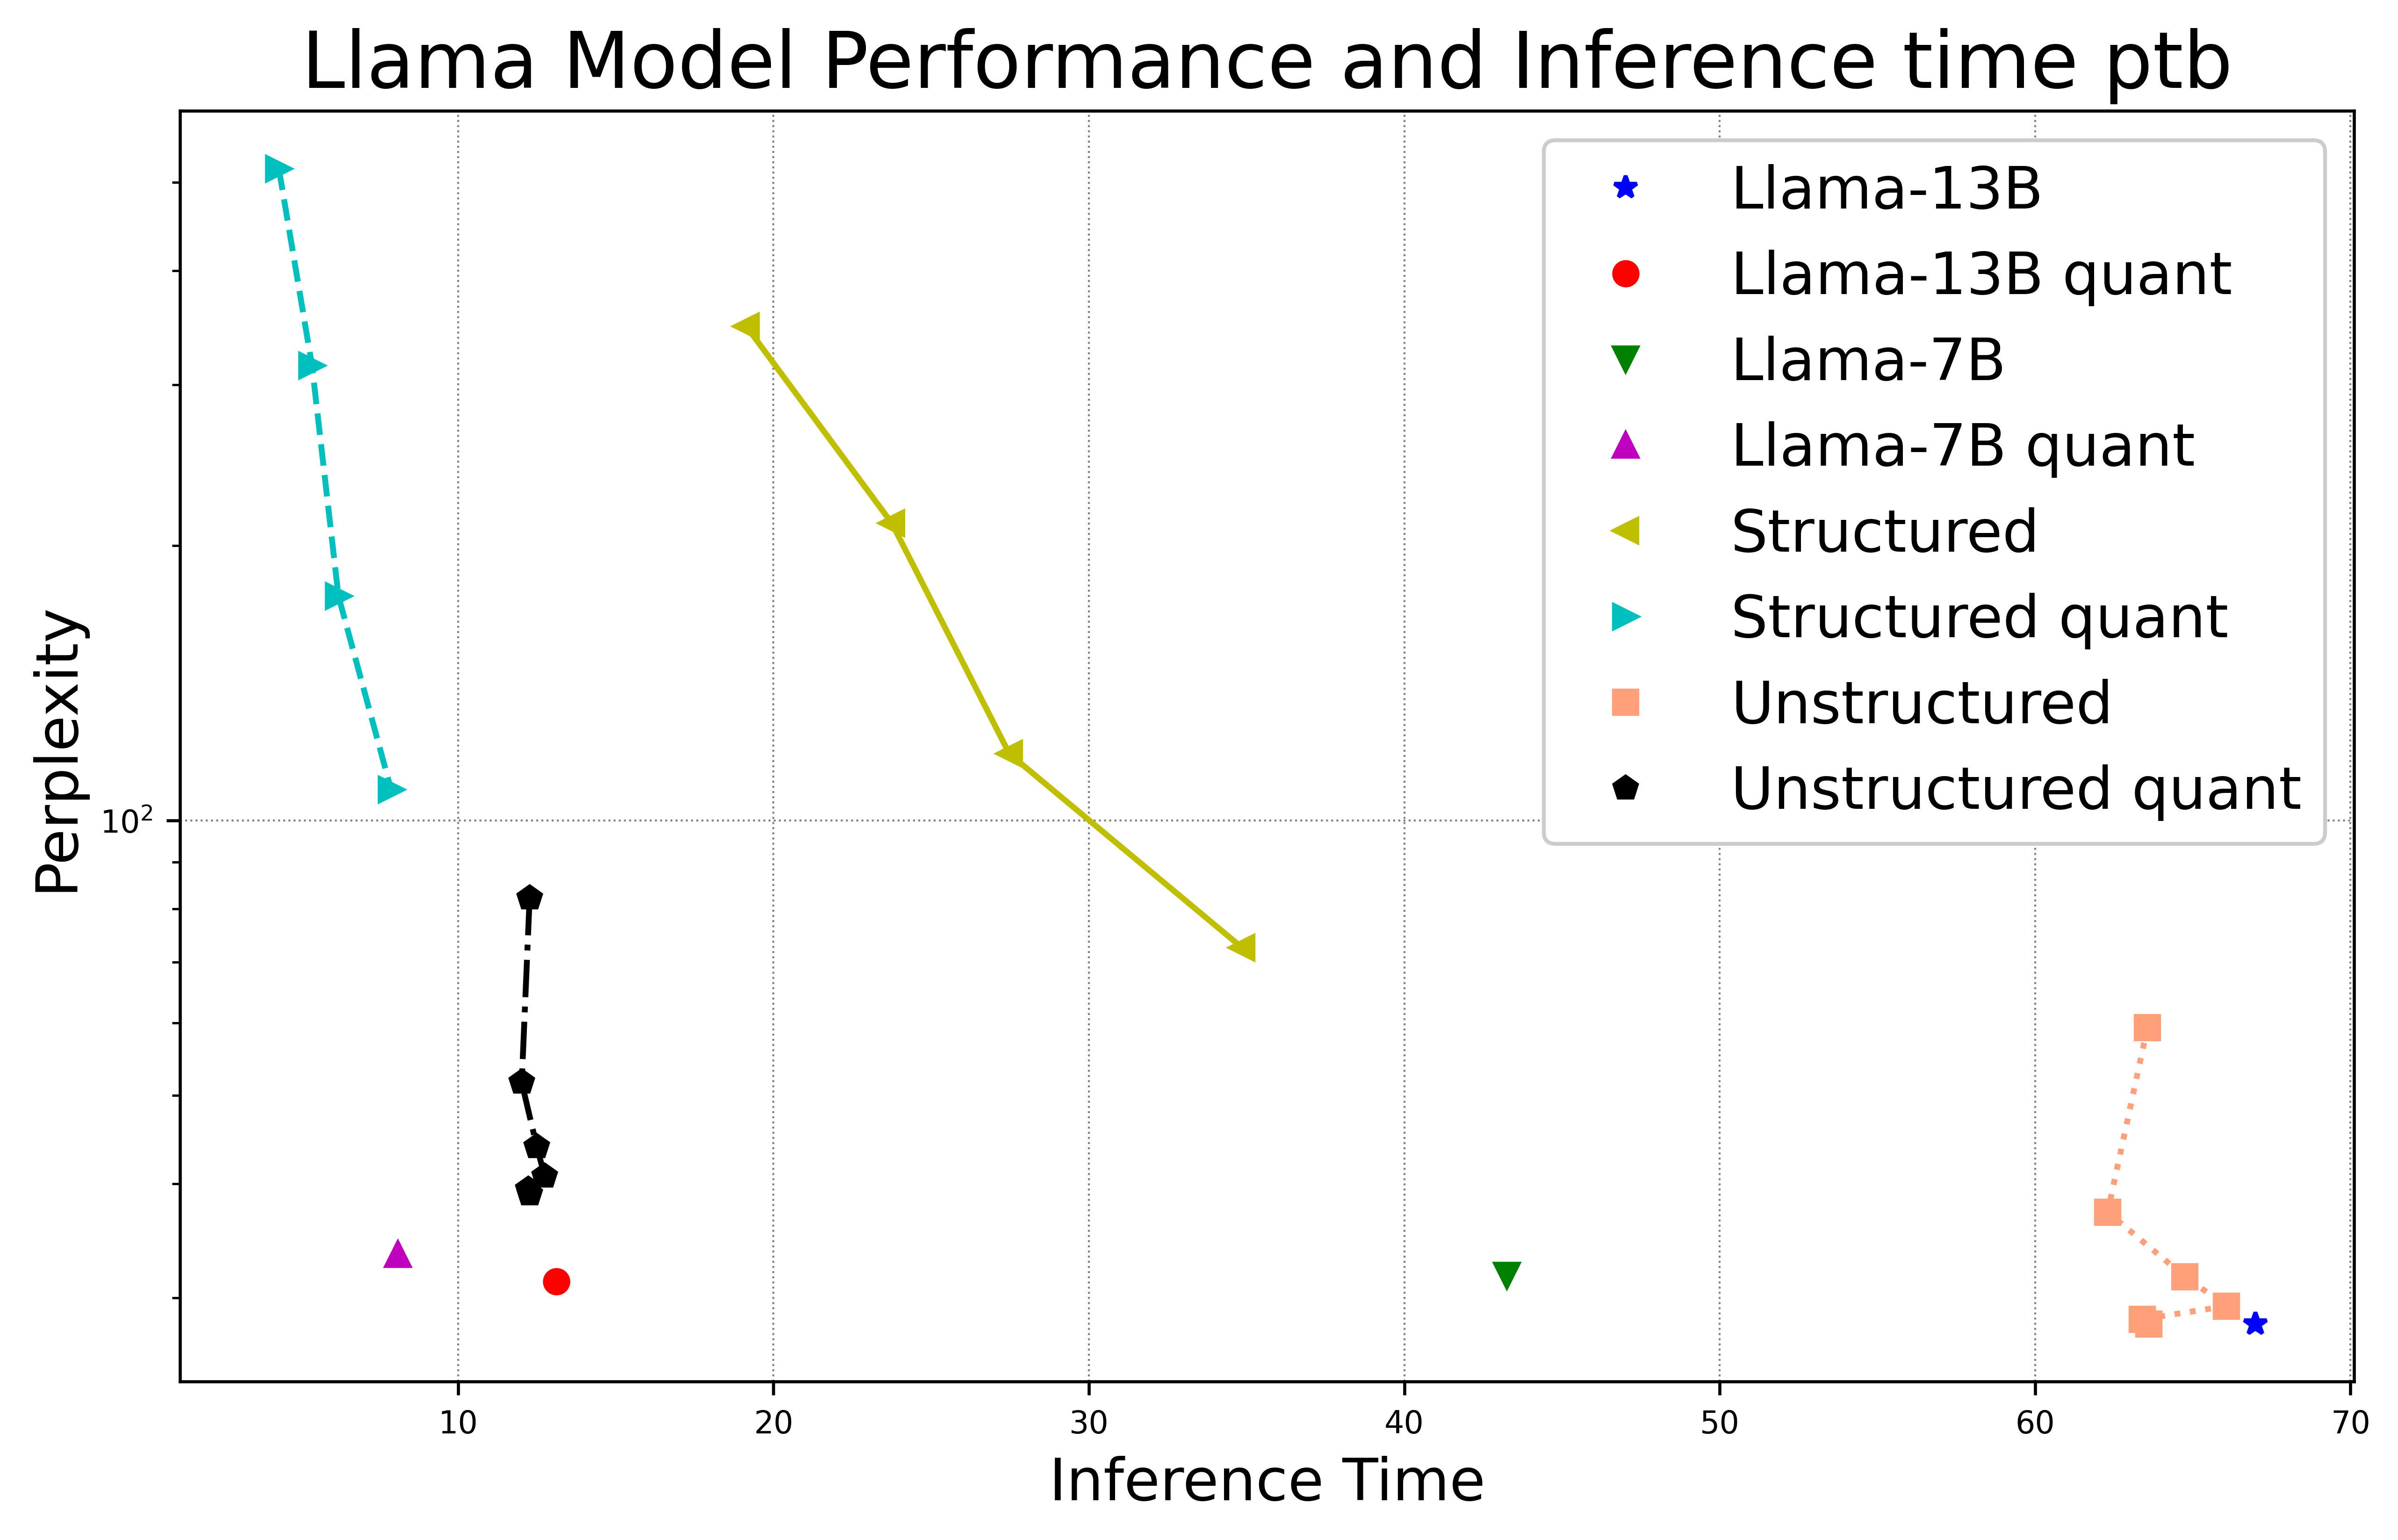

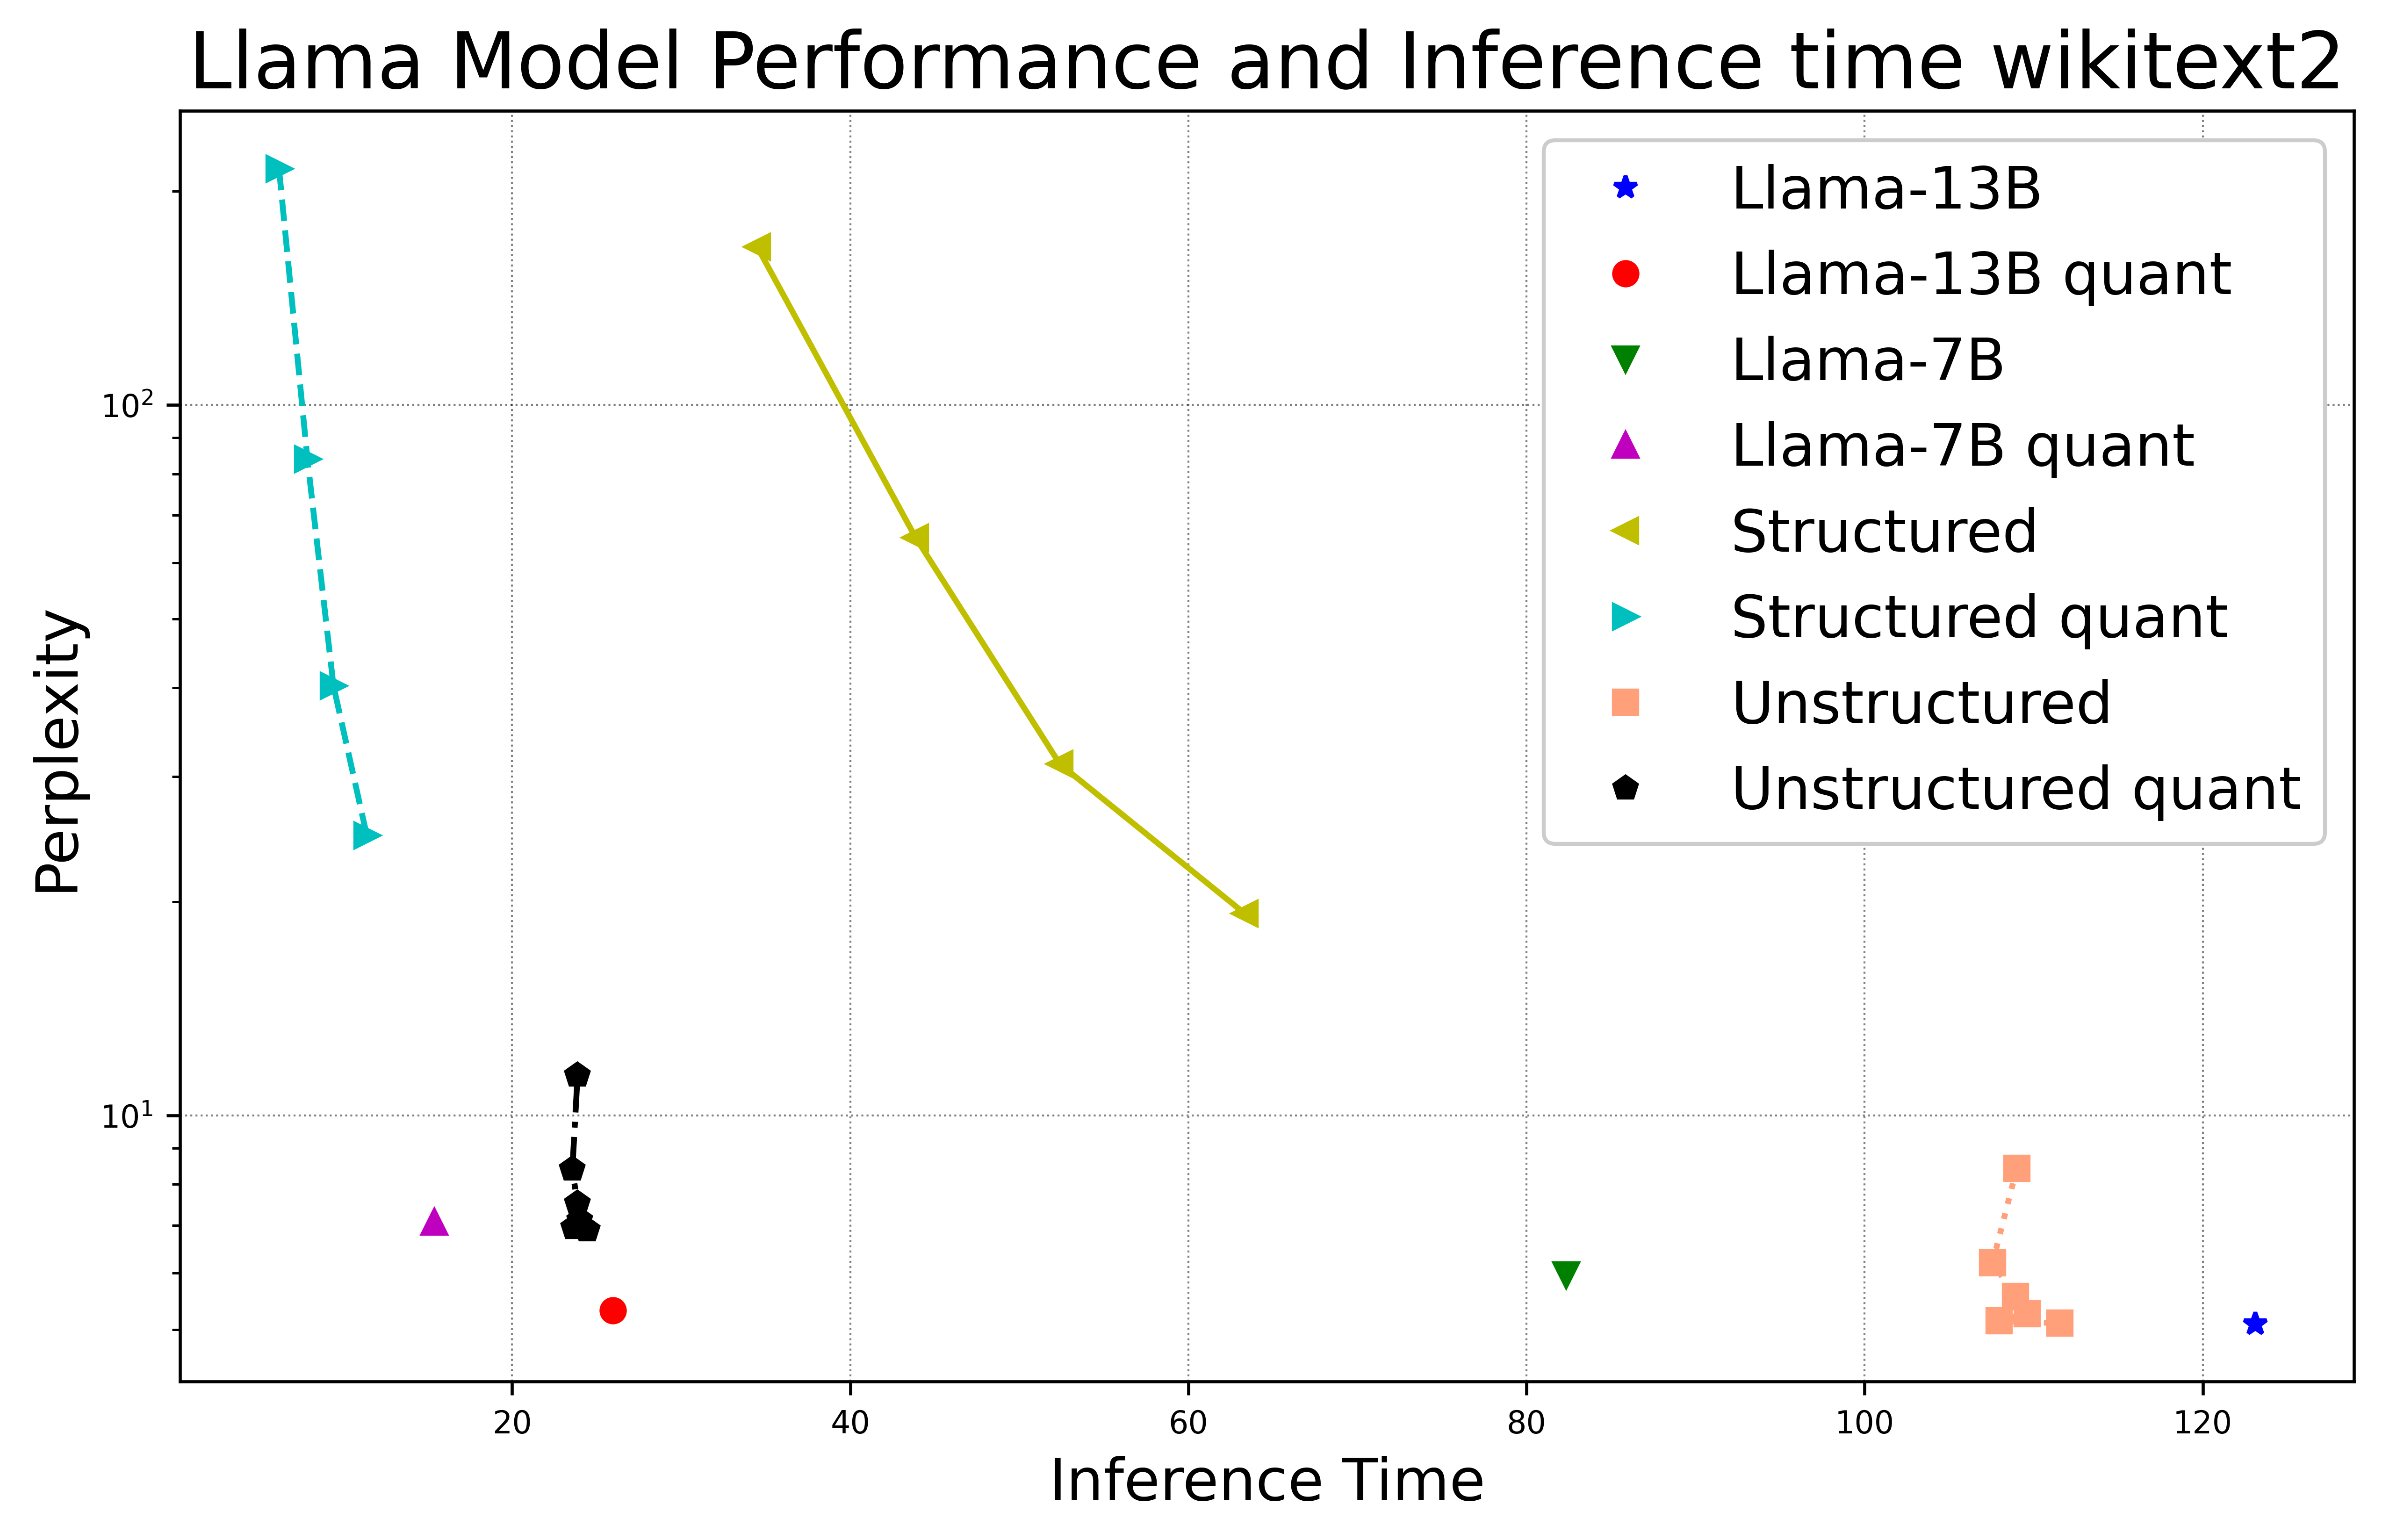

In [52]:
key_x = 'time1'#'Mult-adds(G)'
key_y = 'c4'
markers = ['*','o','v','^','<','>','s','p','1','2','3','4','-','--','-.',':','.',]
colors = ['b','r','g','m','y','c','lightsalmon','black']
key_xs = ['time1','time2','time3']
#with open(save_path+'all_{}_bubble.html'.format(key_x), 'a') as f:
for count1, key_y in enumerate(['c4','ptb','wikitext2']):
    with plt.style.context(['ieee', 'grid', 'no-latex']):
        fig, ax = plt.subplots(figsize=(10,6))
        for count, model in enumerate(np.unique(tmpdf['model'])):
            subdf = tmpdf[tmpdf['model'] == model]
            subdf = subdf.sort_values(by= 'prune_ratio',ascending=False)
            xs, ys = subdf[key_xs[count1]], subdf[key_y]
            #markers_on = [12, 17, 18, 19]
            ax.plot(xs, ys, markers[count],  label=model,color=colors[count])
            ax.plot(xs, ys, color=colors[count])
        ax.set_xlabel('Inference Time',fontsize=15)
        ax.set_ylabel('Perplexity' ,fontsize=15)
        ax.set_title("Llama Model Performance and Inference time {}".format(key_y),fontsize=20)
        #for axis in [ax.xaxis]:
        #    axis.set_major_formatter(LogFormatter())
        #ax.axvline(x=10e4, color='r', ls=':', lw=2)
        ax.legend(fontsize=15)
        plt.yscale('log')
        fig.savefig('figs/performance_infer_time_line_{}.png'.format( key_y))

# performance vs other COMP

In [58]:
tmpdf = df.iloc[11:19,np.array([0,1,3,4,5,6,7,8,9,10,11])]#.reset_index()
tmpdf

model  prune_ratio        c4  time1       ptb  time2  \
11    LLMpruner_block         0.25     22.83  75.19     72.61  34.85   
12    LLMpruner_block         0.40     35.93  61.58    118.33  27.48   
13    LLMpruner_block         0.50     72.13  50.55    211.76  23.75   
14    LLMpruner_block         0.60    180.21  41.34    347.78  19.14   
15  LLMpruner_channel         0.20    176.11  80.82    542.87  36.33   
16  LLMpruner_channel         0.30   3523.53  71.27   4653.21  31.31   
17  LLMpruner_channel         0.40   8038.63  59.99   9774.18  28.71   
18  LLMpruner_channel         0.50  11732.37  50.89  24381.08  24.31   

    wikitext2  time3  Computational Complexity (GMac)  \
11      19.24  63.34                           340.48   
12      31.23  52.40                           292.51   
13      65.10  43.86                           255.84   
14     166.87  34.50                           222.69   
15     144.40  67.45                           340.46   
16    3124.02  58.91                           298.23   
17    8830.24  50.66                           255.90   
18   14558.60  42.68                           213.68   

    Number of Parameters (M)  GPU Memory Requirements (MiB)  
11                   5422.98                       10415.65  
12                   4677.08                        9024.65  
13                   4107.54                        7984.65  
14                   3592.20                        7027.73  
15                   5389.42                       10403.74  
16                   4716.56                        9068.29  
17                   4042.06                        7924.46  
18                   3369.21                        6596.39

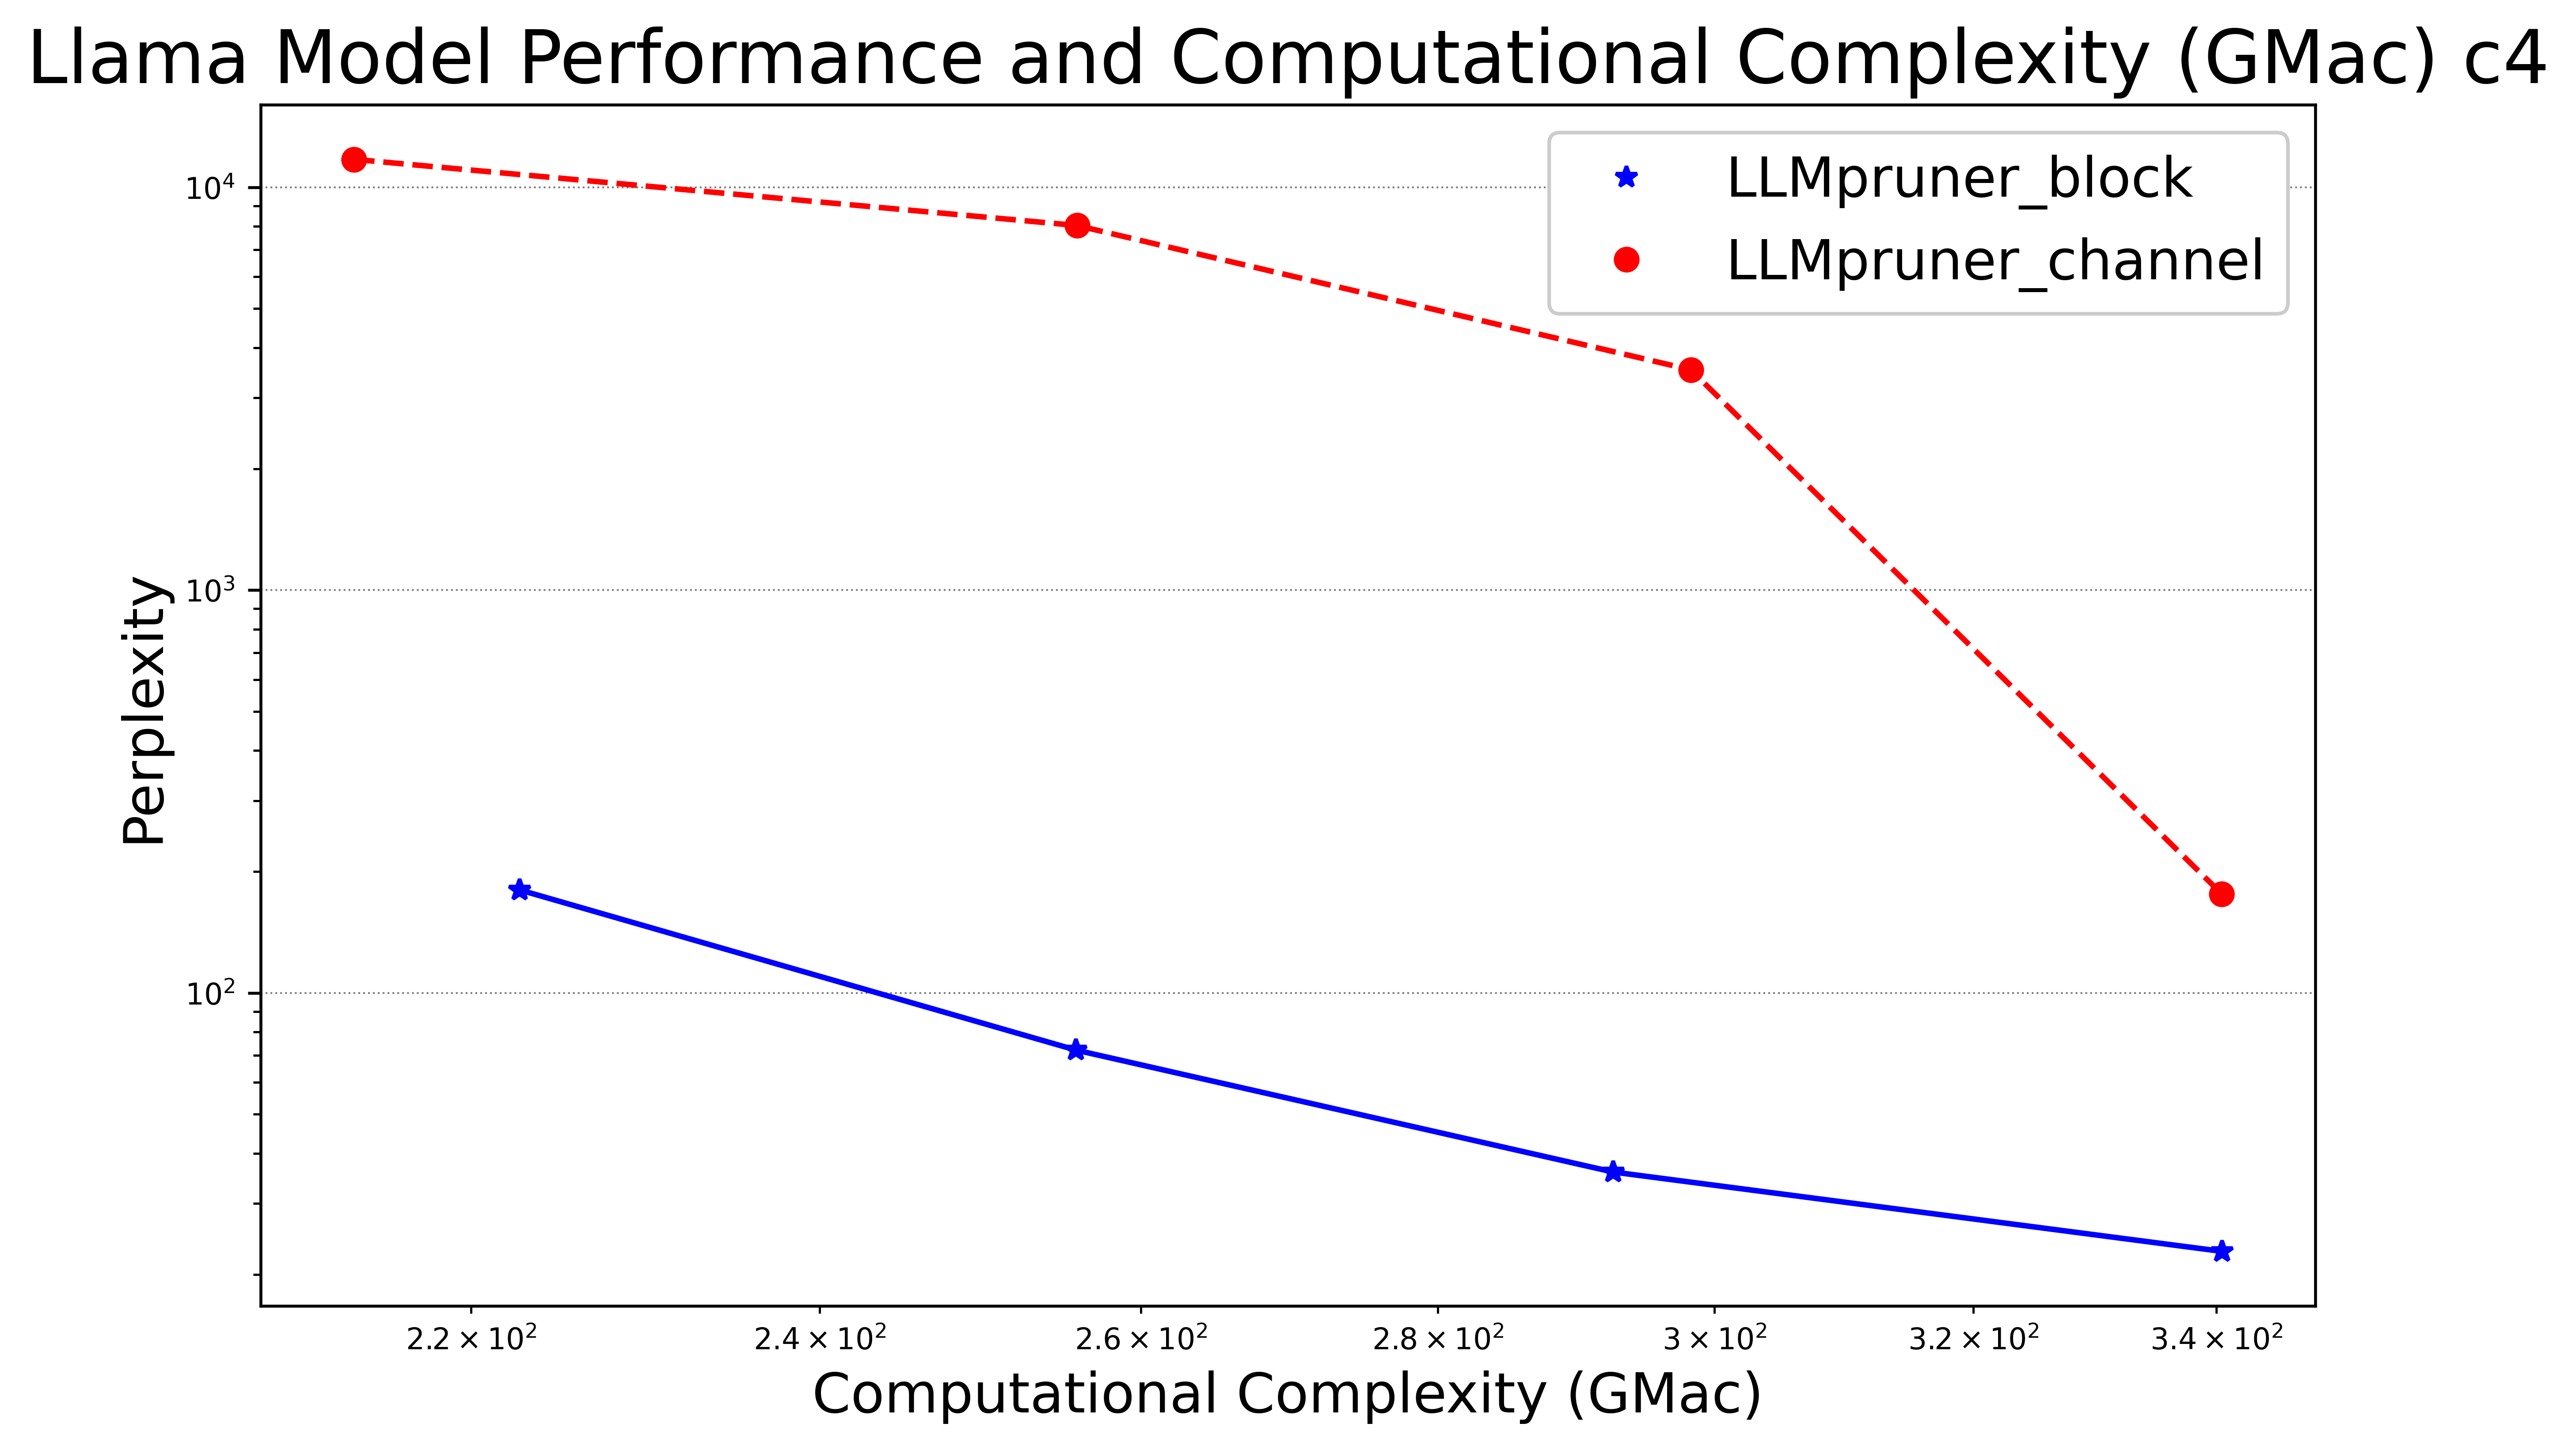

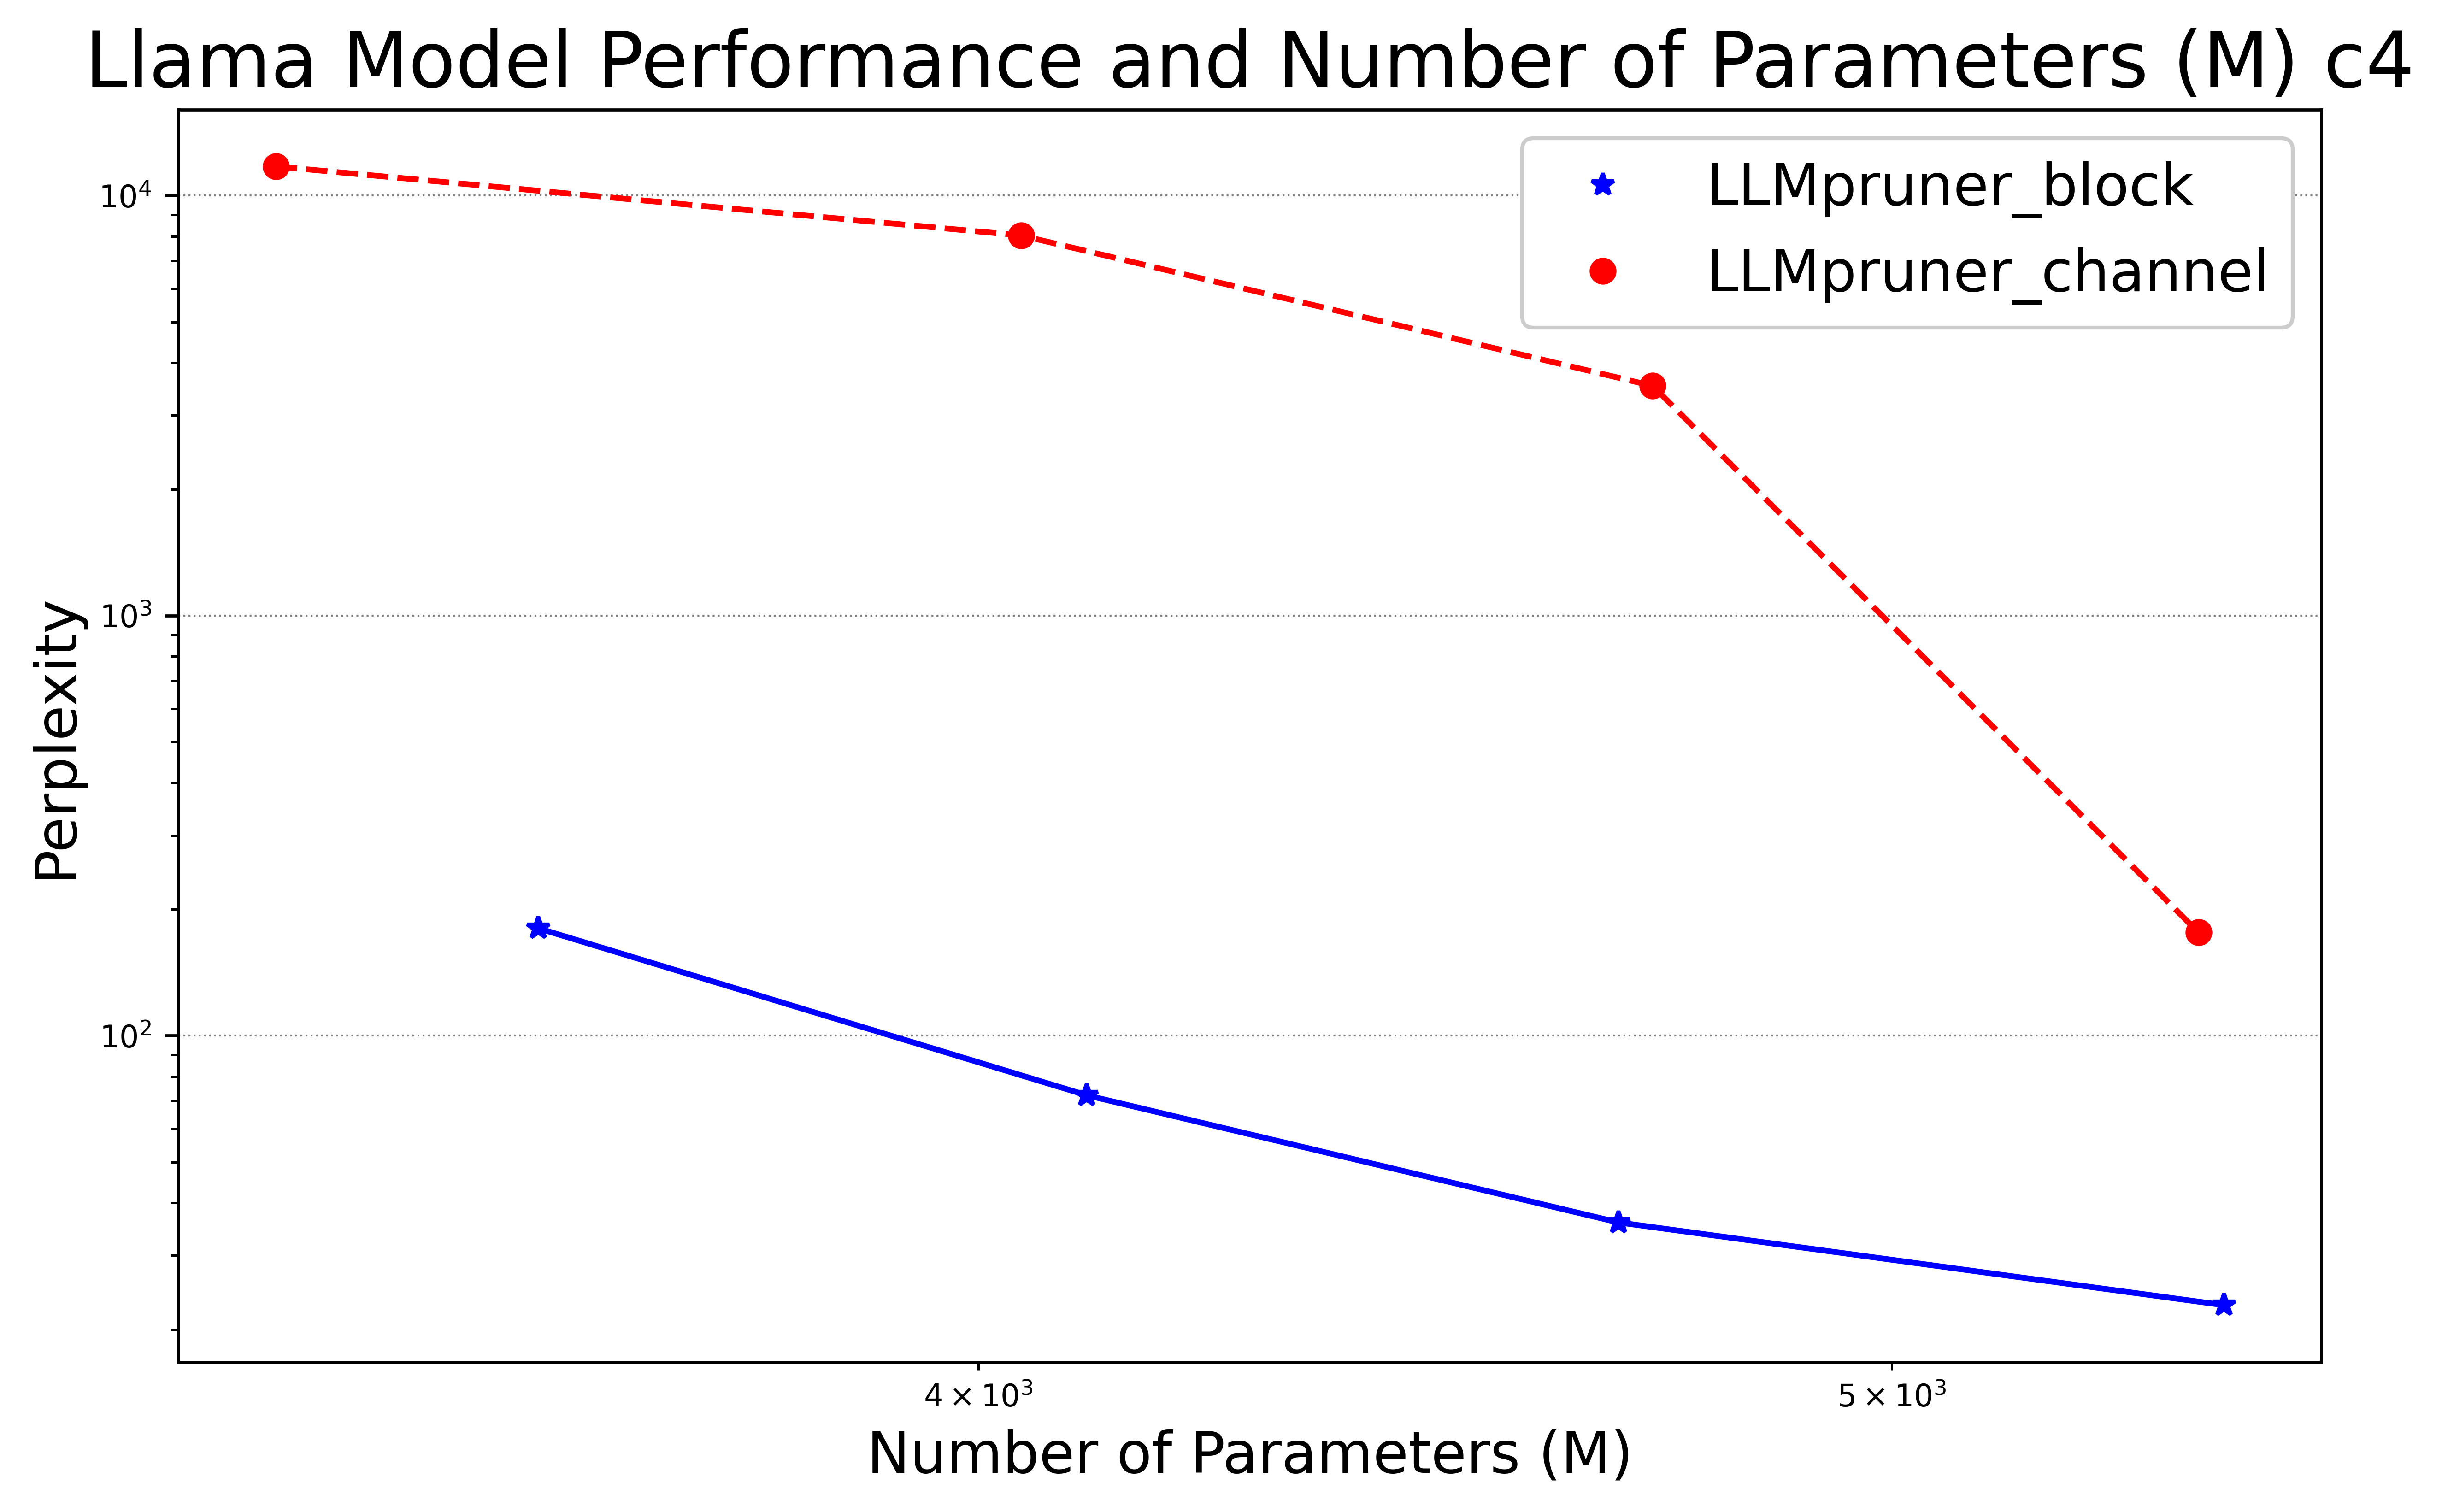

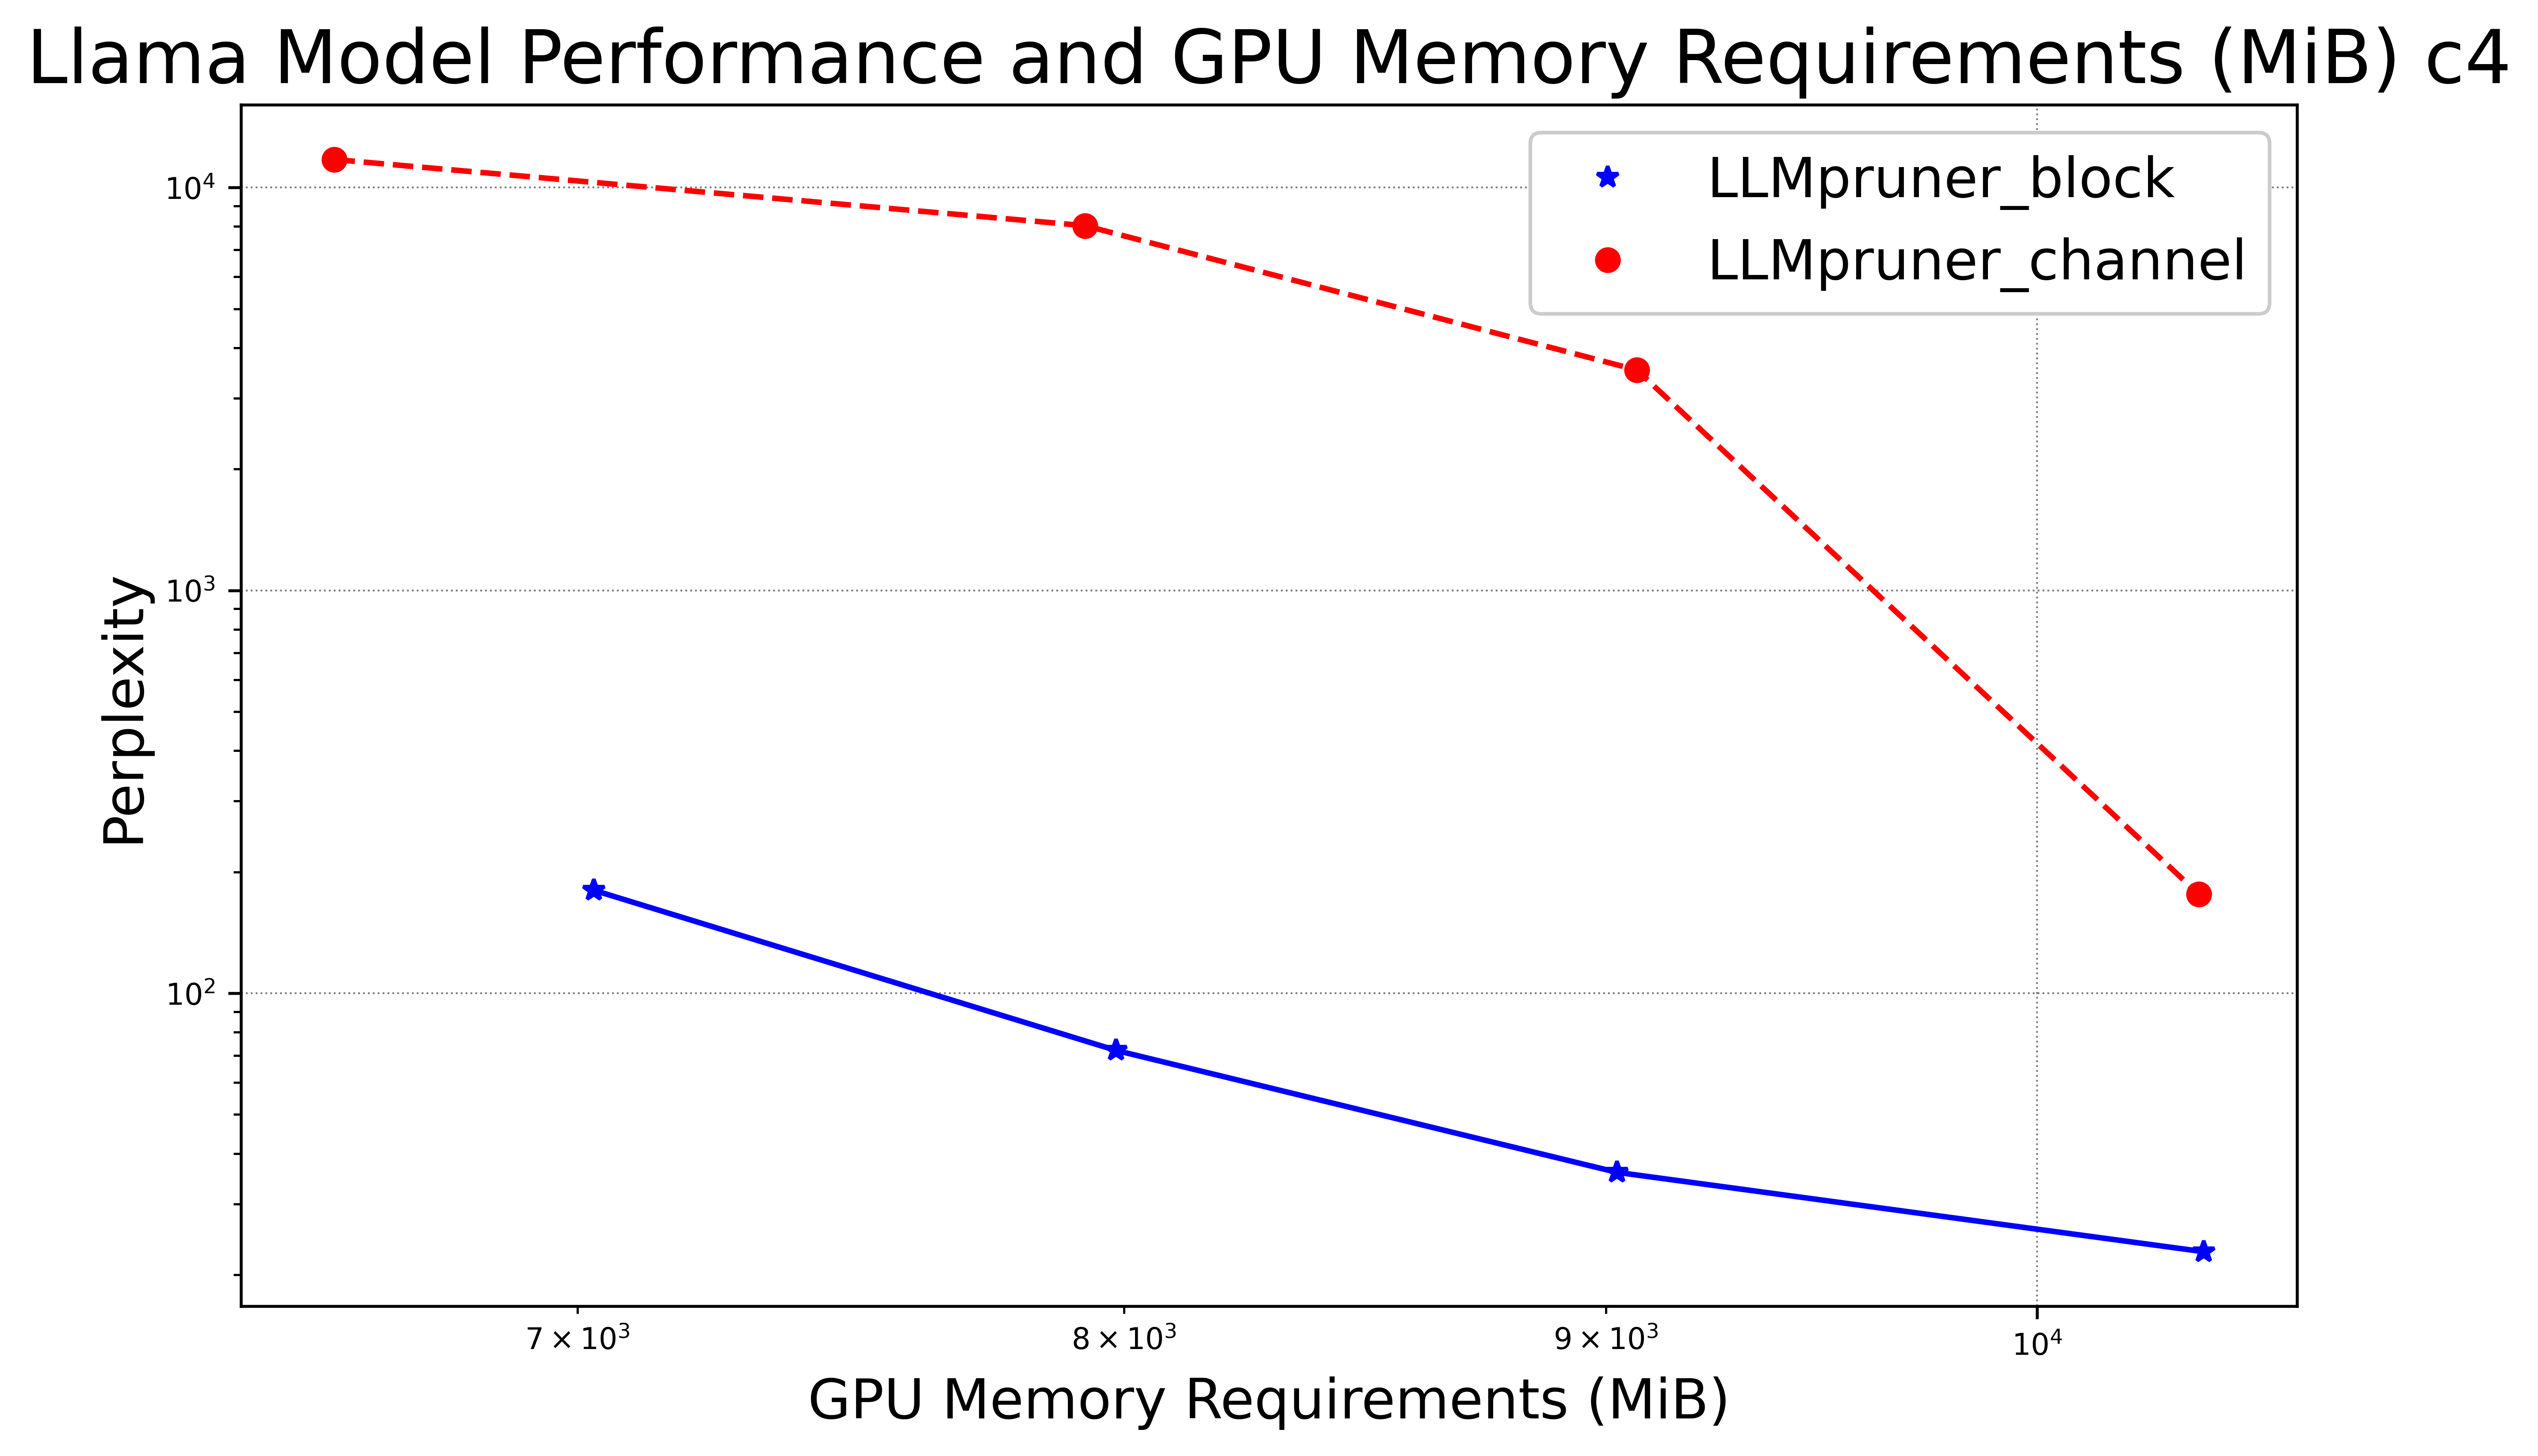

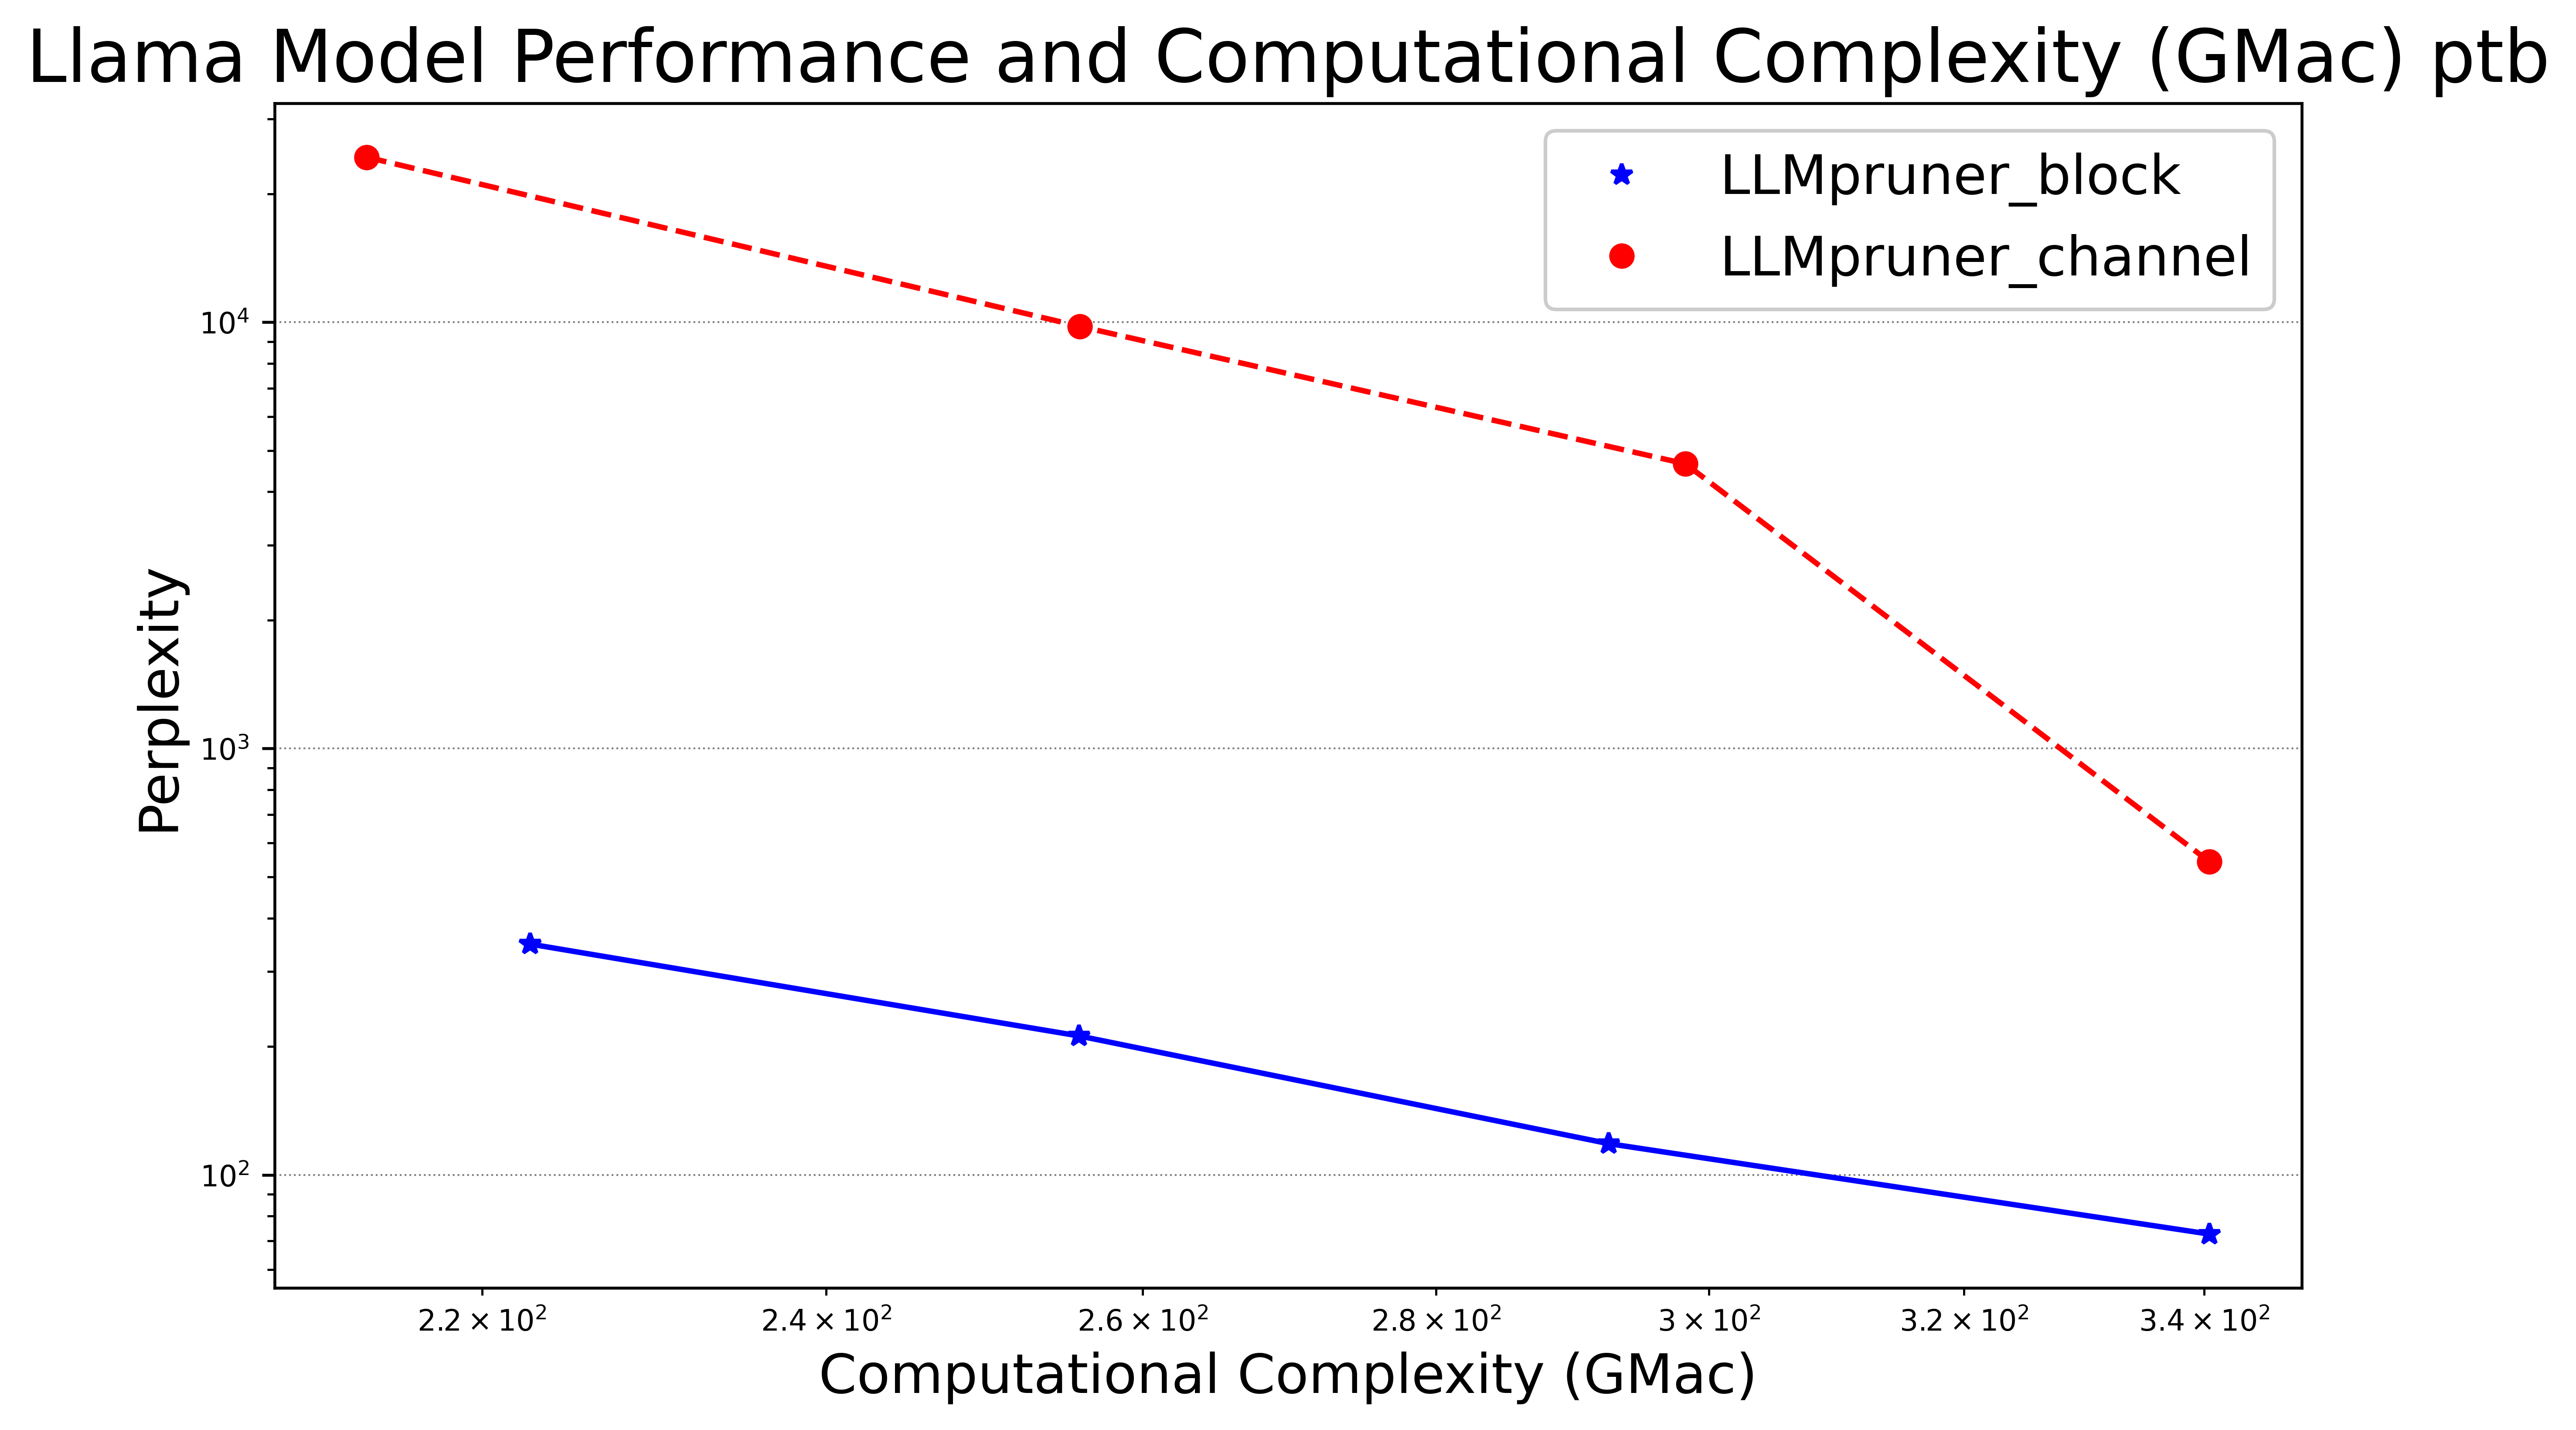

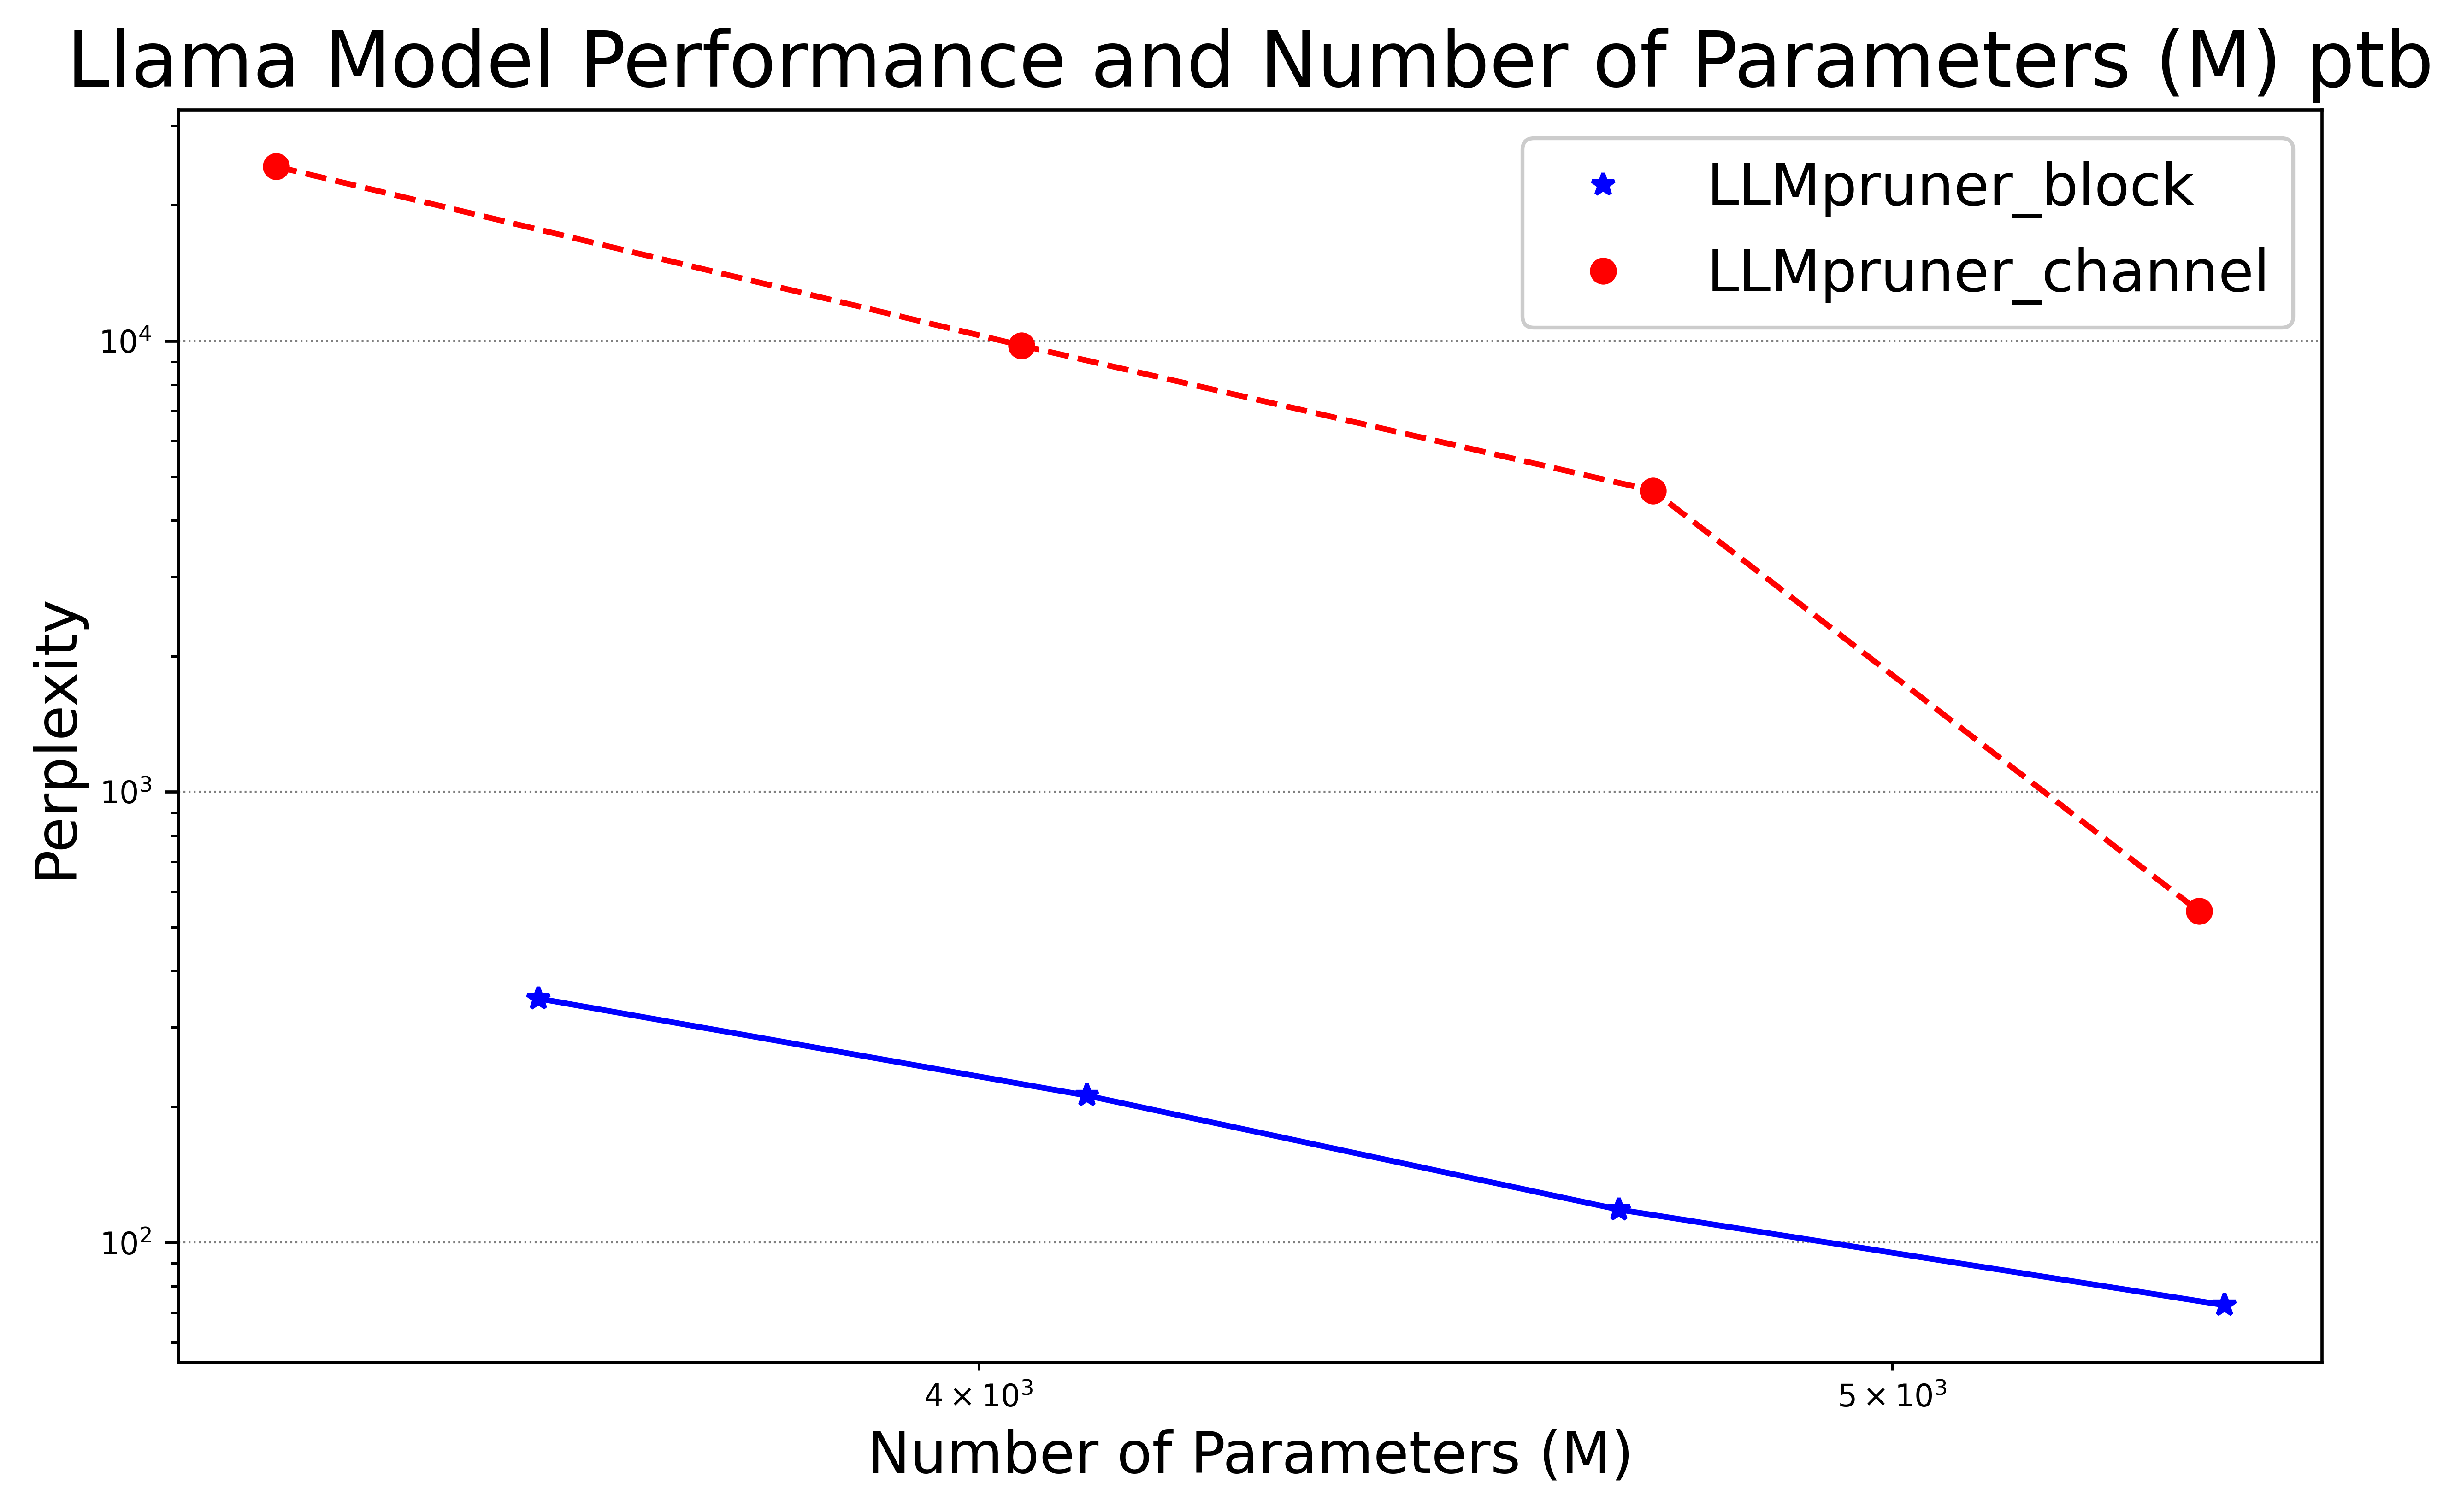

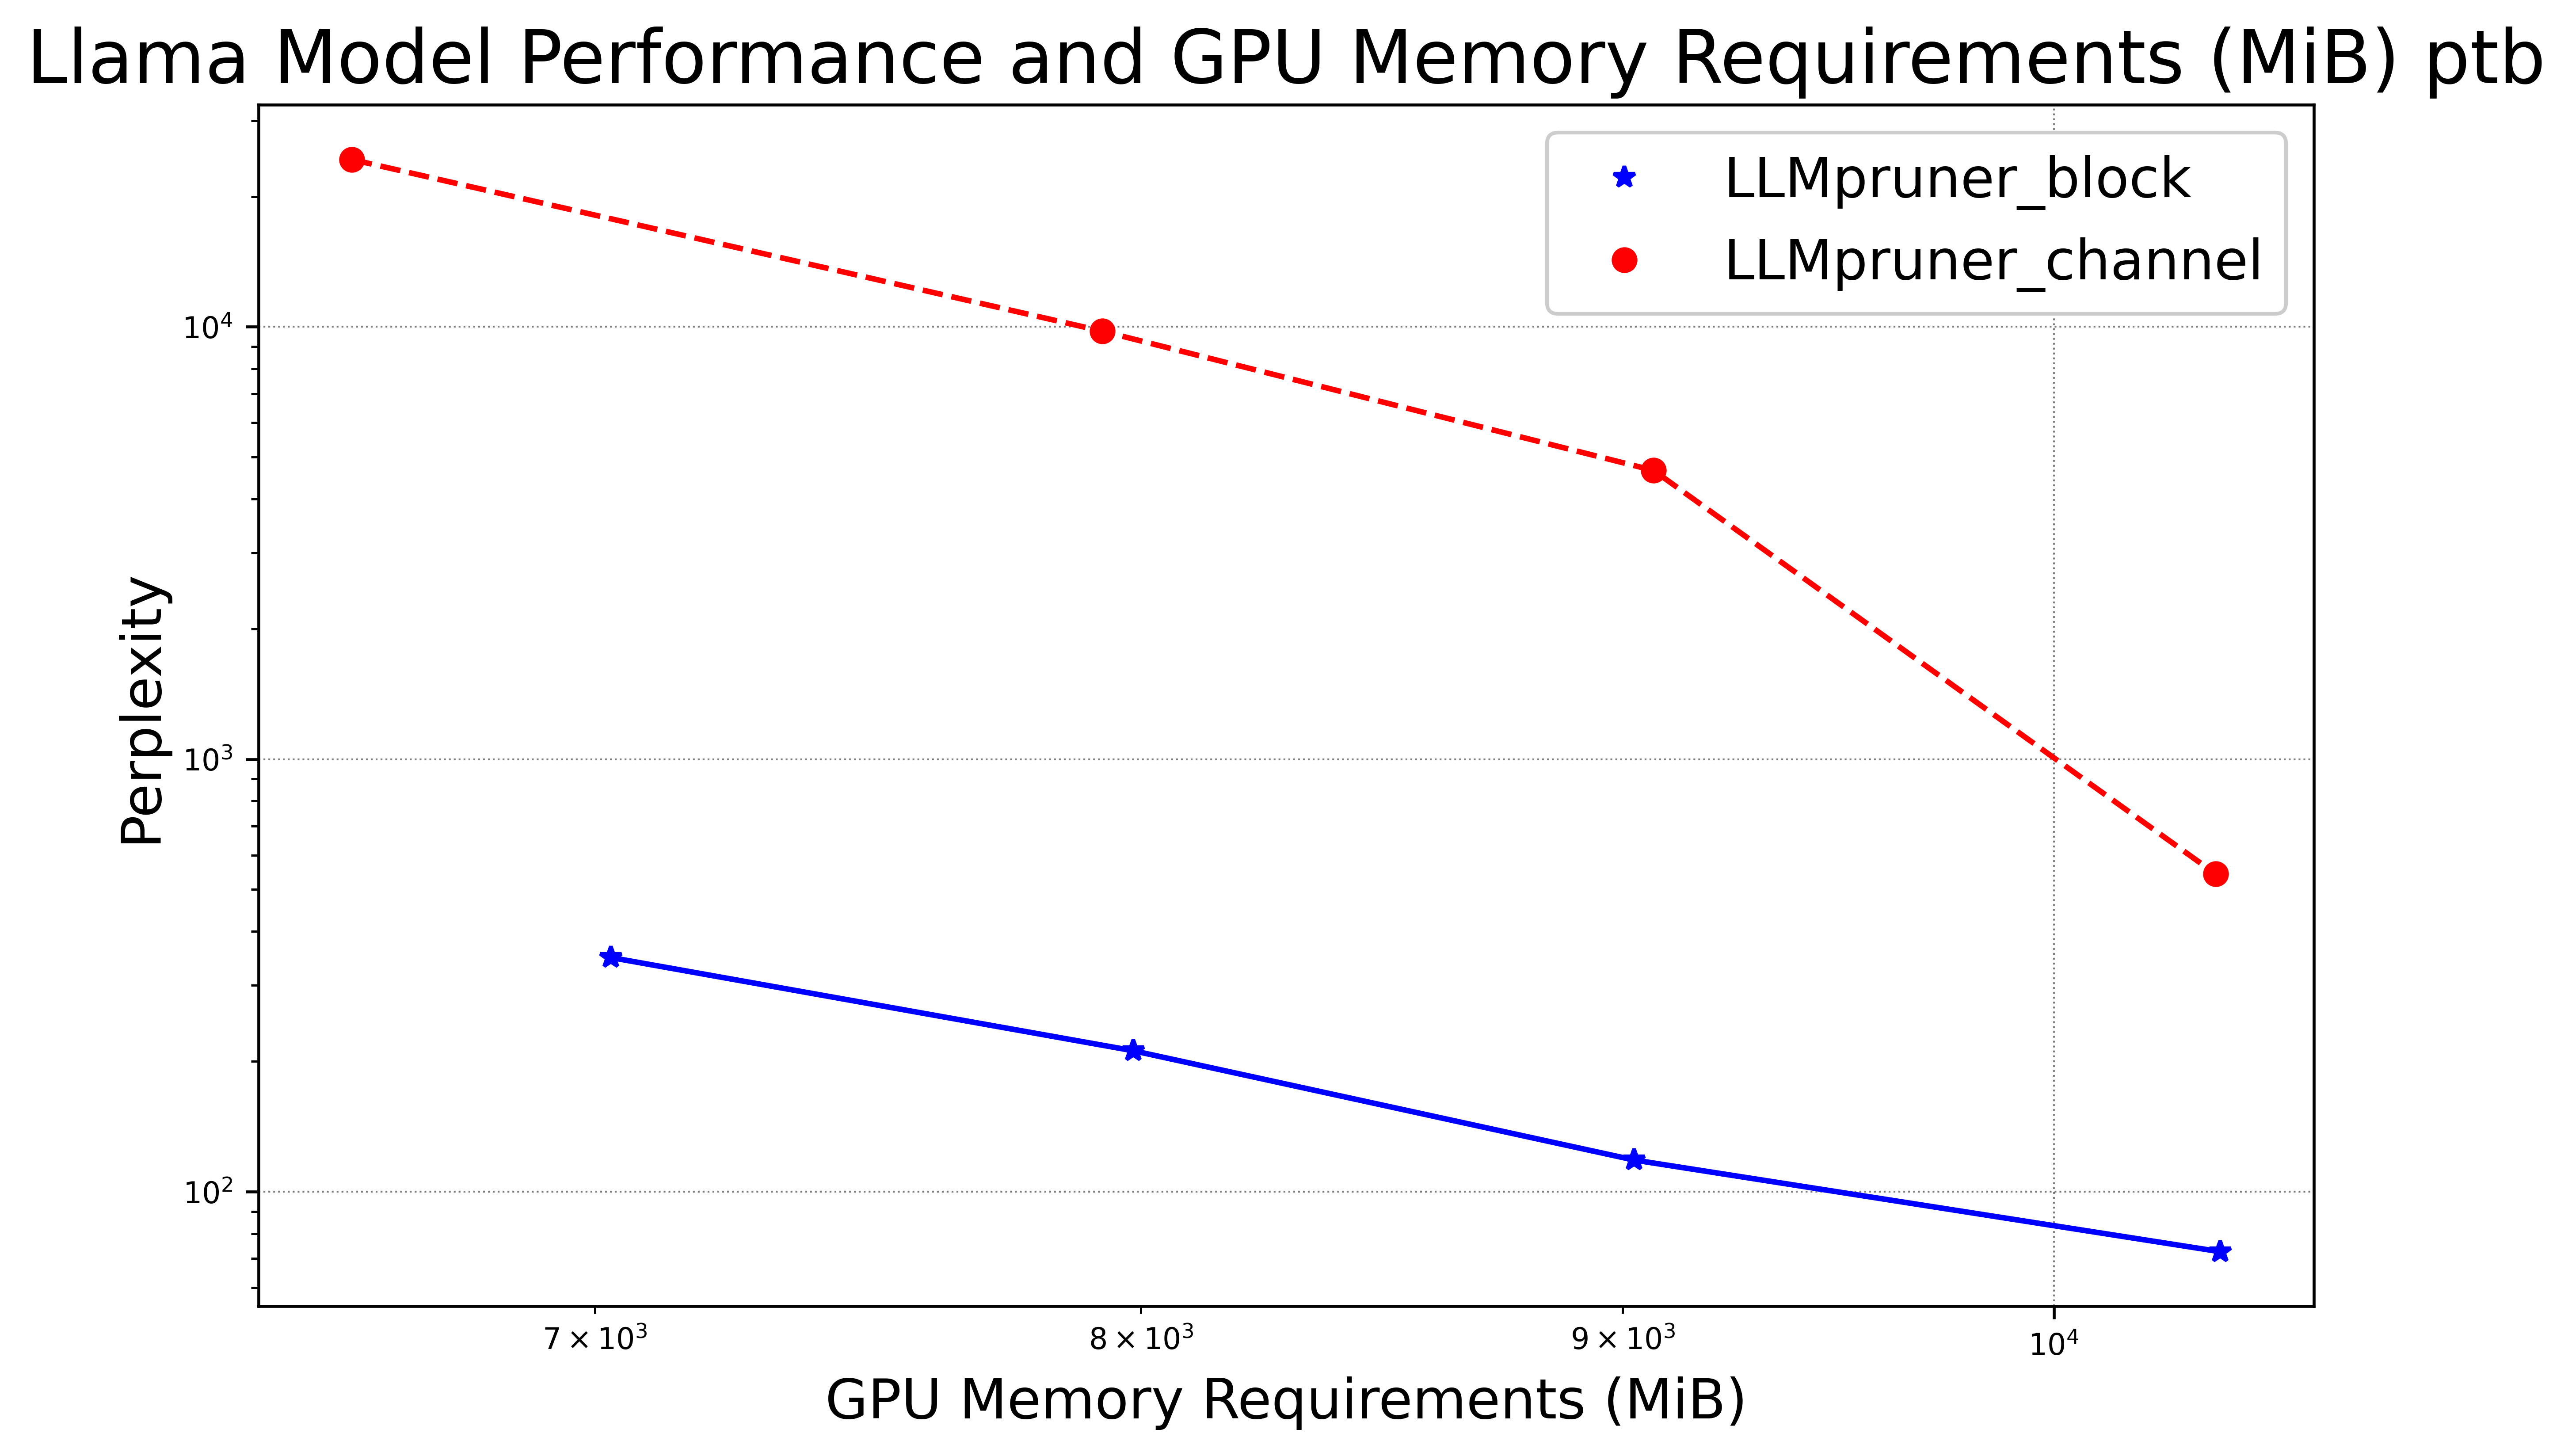

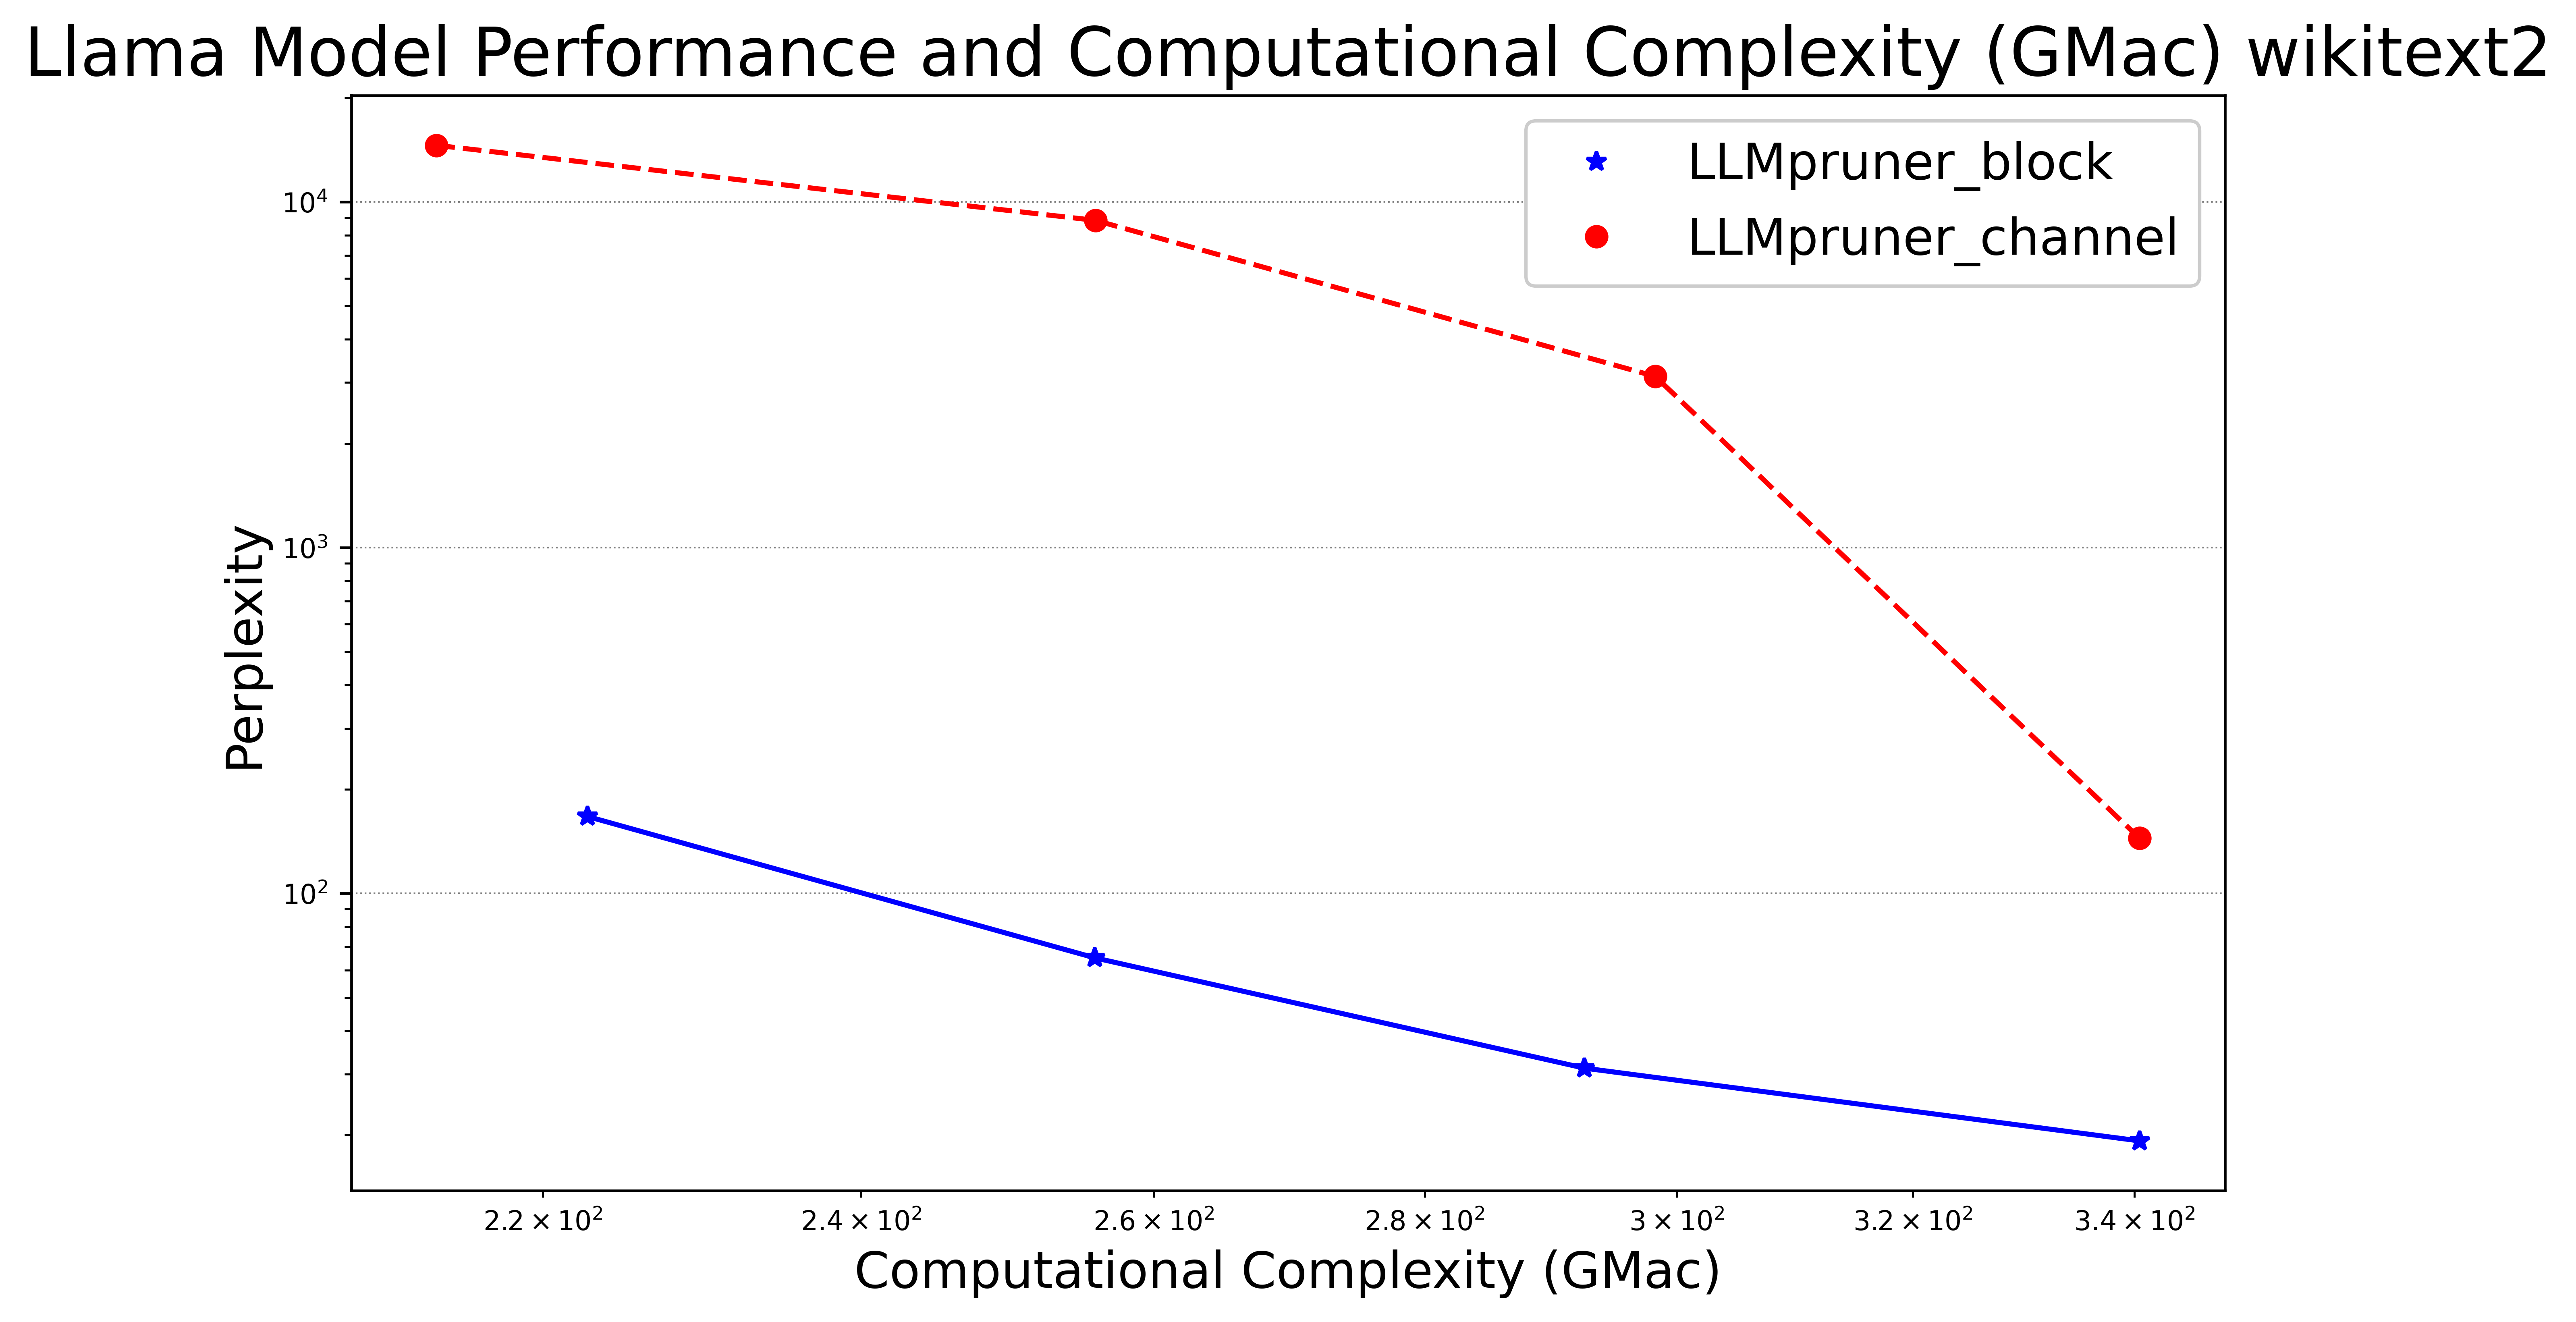

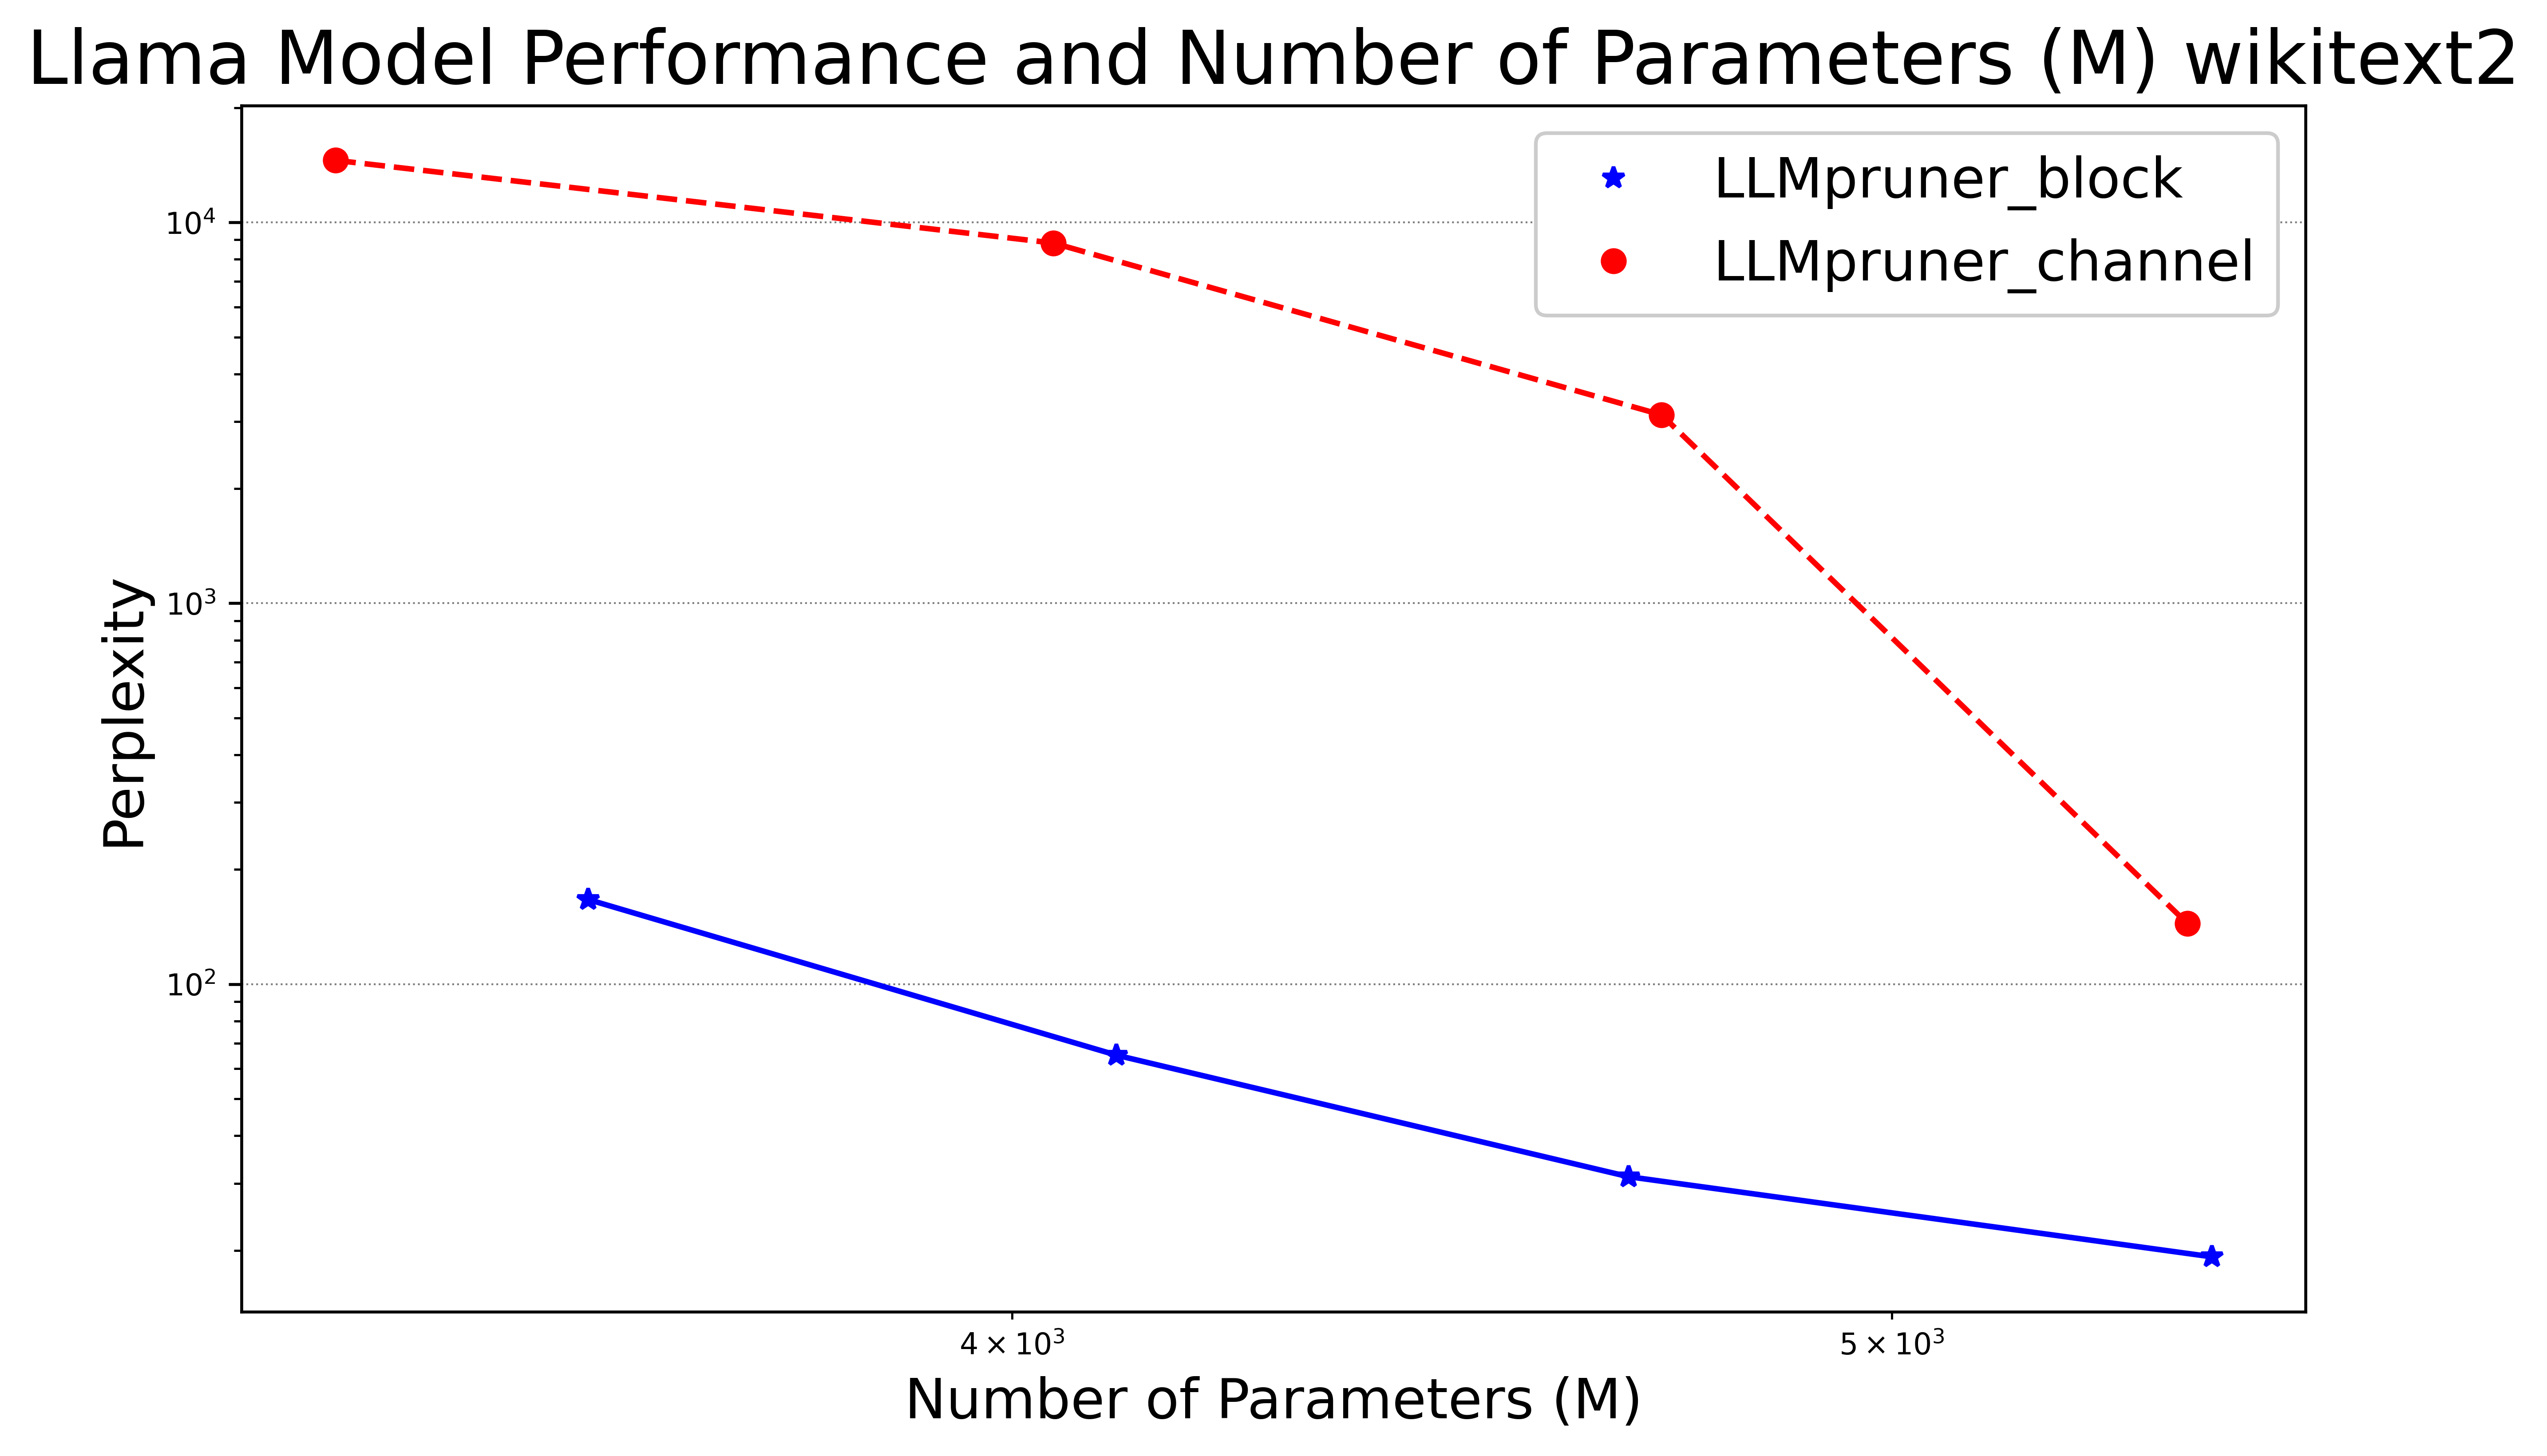

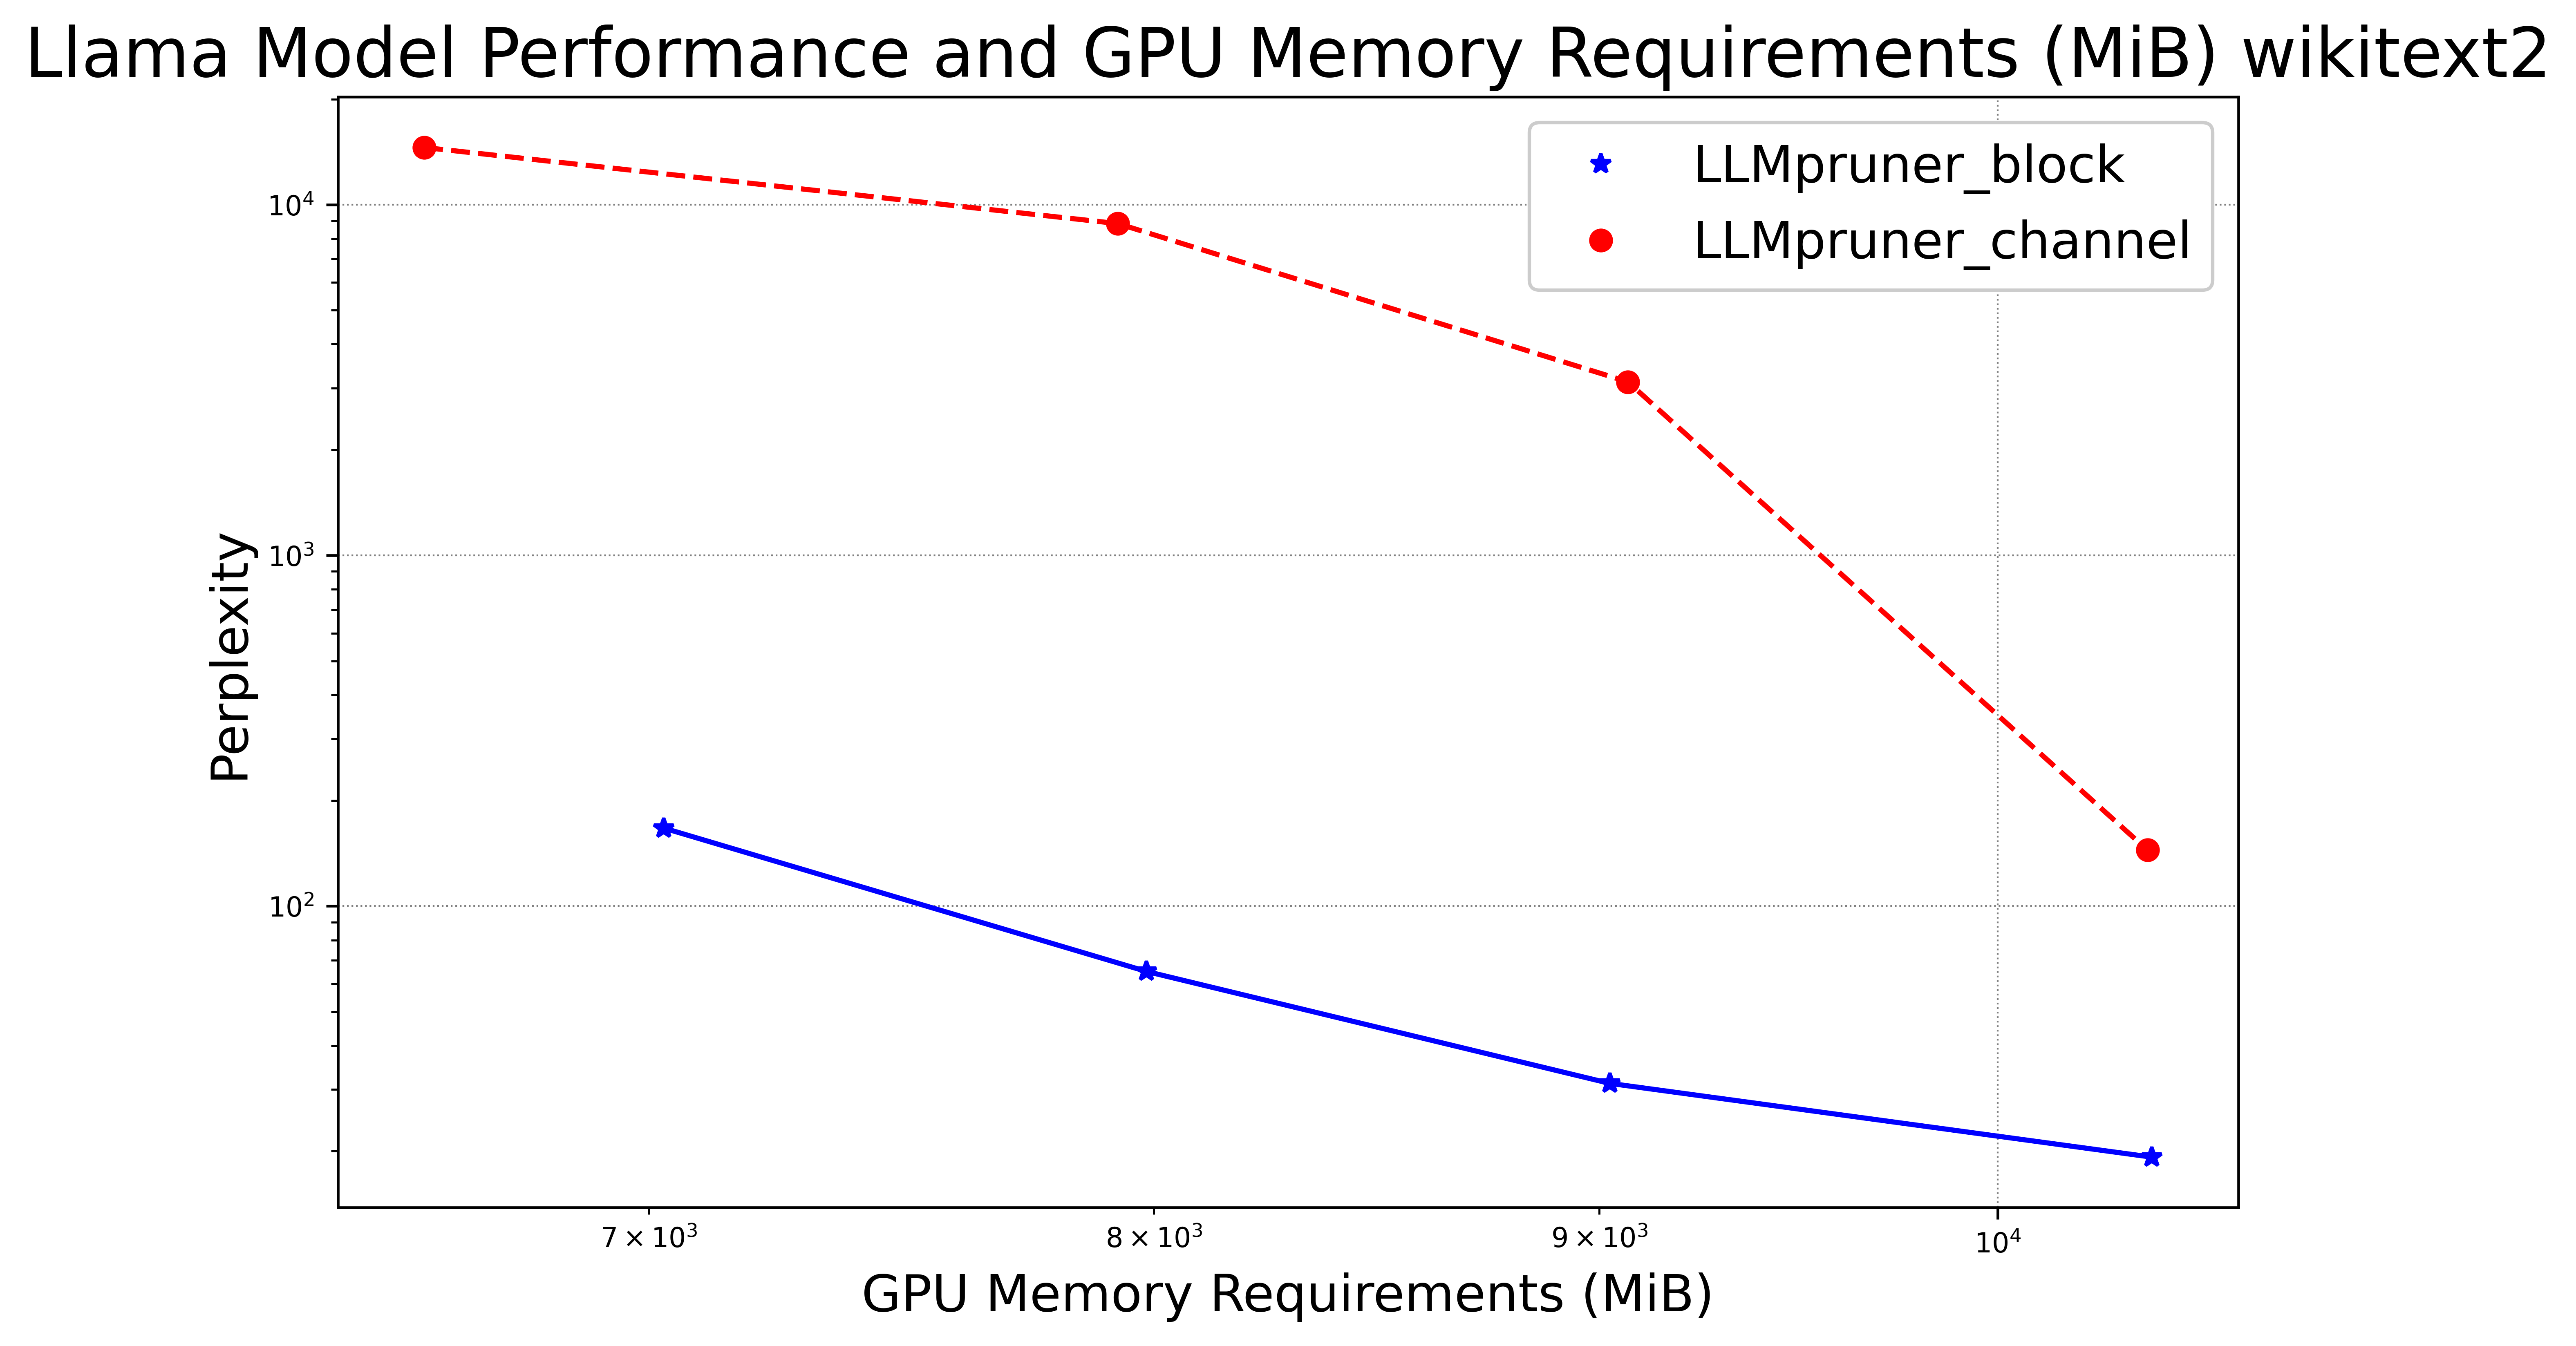

In [59]:
key_xs = ['Computational Complexity (GMac)','Number of Parameters (M)','GPU Memory Requirements (MiB)']
#with open(save_path+'all_{}_bubble.html'.format(key_x), 'a') as f:
for count1, key_y in enumerate([ 'c4','ptb','wikitext2']): #
    for count2 in range(3):
        with plt.style.context(['ieee', 'grid', 'no-latex']):
            fig, ax = plt.subplots(figsize=(10,6))
            for count, model in enumerate(np.unique(tmpdf['model'])):
                subdf = tmpdf[tmpdf['model'] == model]
                subdf = subdf.sort_values(by= 'prune_ratio',ascending=False)
                xs, ys = subdf[key_xs[count2]], subdf[key_y]
                #markers_on = [12, 17, 18, 19]
                ax.plot(xs, ys, markers[count],  label=model,color=colors[count])
                ax.plot(xs, ys, color=colors[count])
            ax.set_xlabel(key_xs[count2],fontsize=15)
            ax.set_ylabel('Perplexity' ,fontsize=15)
            ax.set_title("Llama Model Performance and {} {}".format(key_xs[count2], key_y),fontsize=20)
            #for axis in [ax.xaxis]:
            #    axis.set_major_formatter(LogFormatter())
            #ax.axvline(x=10e4, color='r', ls=':', lw=2)
            ax.legend(fontsize=15)
            plt.yscale('log')
            plt.xscale('log')
            fig.savefig( 'figs/performance_infer_compute_line_{}_{}.png'.format( key_y,key_xs[count2]))